## Final Project Submission

Please fill out:
* Student name: Wesley Yu
* Student pace: Flex
* Scheduled project review date/time: 
* Instructor name: Abhineet Kulkarni
* Blog post URL:

# Time Series Forecasting on House Prices

**Authors:** Wesley Yu
***

## Overview



Time series analysis of house prices.

## Business Problem



Find 5 zipcodes to best invest in.

## Data Understanding



Data from zillow. seasonaly adjusted.

In [2]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error

from pmdarima import auto_arima

#statsmodels
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Load the Data/Filtering for Chosen Zipcodes

In [3]:
df = pd.read_csv('data/zillow_data.csv')
df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [253]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14723 entries, 0 to 14722
Columns: 272 entries, RegionID to 2018-04
dtypes: float64(219), int64(49), object(4)
memory usage: 30.6+ MB


In [254]:
df[df.Metro == 'New York']['CountyName'].value_counts()

Suffolk        89
Bergen         65
Nassau         63
Westchester    61
Queens         55
Monmouth       47
Morris         43
Middlesex      34
Orange         30
Ocean          29
Kings          28
Union          26
Dutchess       25
Passaic        25
Essex          25
Rockland       23
Somerset       21
Hunterdon      18
Sussex         15
Hudson         13
Bronx          13
Richmond       12
Putnam          7
Pike            6
New York        6
Name: CountyName, dtype: int64

In [4]:
ny_df = df[(df.Metro == 'New York')&(df.CountyName.isin(['Kings', 'Richmond', 'Queens', 'Bronx']))]

In [255]:
ny_df.shape

(106, 274)

There are 106 zip codes within the 4 boroughs.

In [11]:
ny_df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,3_yr_roi
6,61807,10467,New York,NY,New York,Bronx,7,152900.0,152700.0,152600.0,...,400000,407300,411600,413200,414300,413900,411400,413200,417900,0.196050
10,62037,11226,New York,NY,New York,Kings,11,162000.0,162300.0,162600.0,...,851000,853900,870000,885100,887800,890500,901700,930700,963200,0.399390
12,62087,11375,New York,NY,New York,Queens,13,252400.0,251800.0,251400.0,...,1033700,1048600,1066400,1081200,1088800,1092700,1089500,1084000,1084600,0.267648
13,62045,11235,New York,NY,New York,Kings,14,190500.0,191000.0,191500.0,...,777300,788800,793900,796000,799700,806600,810600,813400,816200,0.304251
35,61802,10462,New York,NY,New York,Bronx,36,154300.0,154300.0,154400.0,...,436100,439900,443500,444100,443900,446000,446400,447200,450200,0.230727


# Data Preprocessing

In [263]:
ny_df.iloc[:, 0:7].isnull().sum()

RegionID      0
RegionName    0
City          0
State         0
Metro         0
CountyName    0
SizeRank      0
dtype: int64

In [264]:
ny_df.iloc[:, 7:].isnull().sum()

1996-04    6
1996-05    6
1996-06    6
1996-07    6
1996-08    6
          ..
2017-12    0
2018-01    0
2018-02    0
2018-03    0
2018-04    0
Length: 265, dtype: int64

Some zip codes have null values in certain periods.

In [265]:
ny_df.iloc[:, 7:].isnull().sum().sum()

768

In [266]:
ny_df[ny_df['1996-04'].isna()]

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
36,61796,10456,New York,NY,New York,Bronx,37,NaN,NaN,NaN,...,357900,357100,356500,357200,362000,368500,374100,379800,388100,394400
156,62048,11238,New York,NY,New York,Kings,157,NaN,NaN,NaN,...,2673300,2696700,2716500,2724000,2744300,2768900,2810700,2848100,2869600,2885300
1299,62004,11101,New York,NY,New York,Queens,1300,NaN,NaN,NaN,...,760100,739000,708300,698500,711200,742900,767300,769700,767200,782500
1413,61799,10459,New York,NY,New York,Bronx,1414,NaN,NaN,NaN,...,337200,334600,328700,332200,349300,370100,383000,393400,403900,410400
1434,62016,11205,New York,NY,New York,Kings,1435,NaN,NaN,NaN,...,2267400,2230800,2226800,2241400,2248400,2251000,2251600,2245300,2243700,2248400
1534,62028,11217,New York,NY,New York,Kings,1535,NaN,NaN,NaN,...,3405900,3442900,3443800,3426000,3407000,3404100,3413800,3482900,3588100,3656000


After closer examination missing values seem to be only at the earlier periods.

In [267]:
ny_df[ny_df['1996-04'].isna()].isna().sum(axis = 1)

36      213
156      93
1299    189
1413     87
1434     93
1534     93
dtype: int64

10456 and 11101 are some missing values from the period I plan to exam, 2011 and onwards. I will drop them from data frame. 

In [5]:
ny_df.drop(index = [36, 1299], inplace = True)

C:\Users\Martian\Anaconda3\envs\learn-env\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


# EDA and Visualization

In [5]:
ny_df_mean = ny_df.iloc[:, 7:].mean() # compute values for average price of all zipcodes in our subset

In [6]:
ny_df_mean.index = pd.to_datetime(ny_df_mean.index)

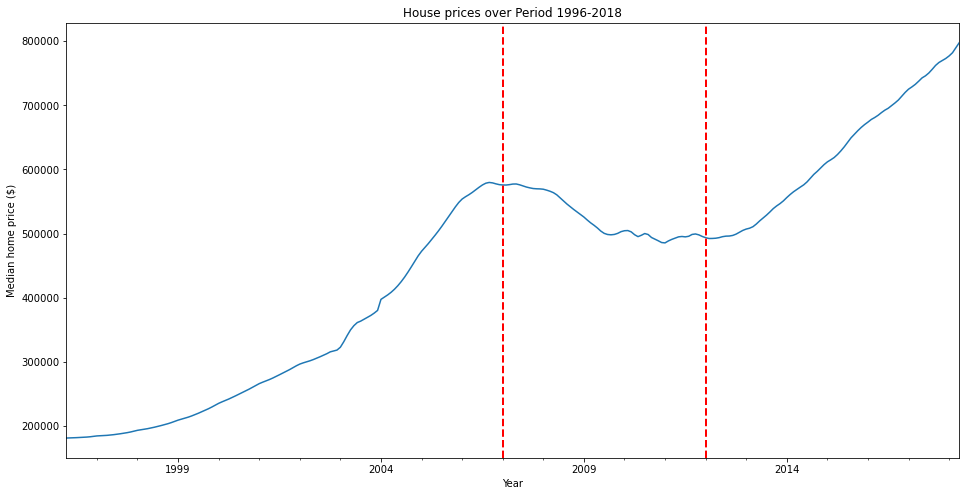

In [7]:
plt.figure(figsize=(16,8))
ny_df_mean.plot()
plt.title('House prices over Period 1996-2018')
plt.ylabel('Median home price ($)')
plt.xlabel('Year')
plt.axvline(pd.to_datetime('2007-01-01'), color = 'r', linestyle='--', lw=2)
plt.axvline(pd.to_datetime('2012-01-01'), color = 'r', linestyle='--', lw=2);

Average prices show a decline starting around 2007 and start to rise again after 2011, which can be explain by the subprime mortgage crisis. I will use values from 2011 onward to model forecasts for the future.

<AxesSubplot:>

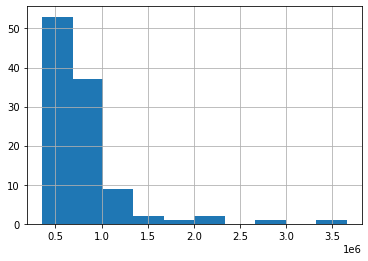

In [6]:
ny_df['2018-04'].hist()

In [7]:
ny_df['2018-04'].describe()

count    1.060000e+02
mean     7.976717e+05
std      4.903511e+05
min      3.567000e+05
25%      4.916750e+05
50%      6.859000e+05
75%      9.172500e+05
max      3.656000e+06
Name: 2018-04, dtype: float64

Majority of house prices are under 1 million. 

<AxesSubplot:xlabel='CountyName', ylabel='2018-04'>

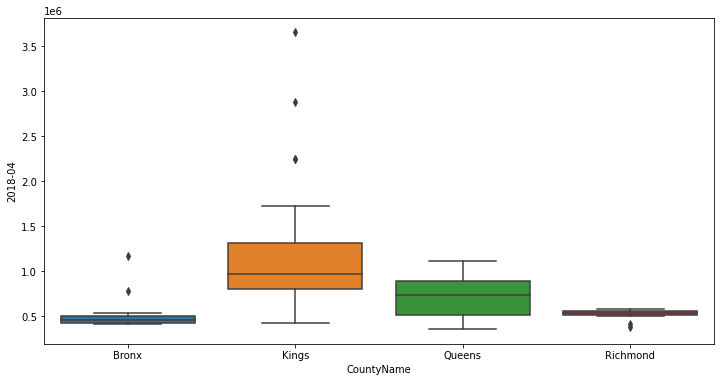

In [14]:
plt.figure(figsize = (12,6))
sns.boxplot(x = 'CountyName', y = '2018-04', data = ny_df);

Kings county have higher average house prices compared to others.

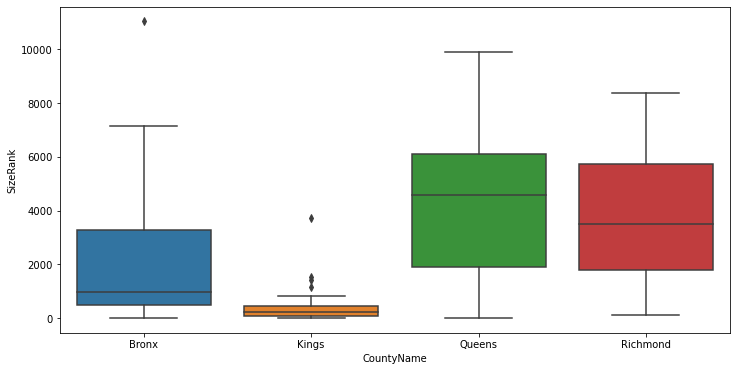

In [6]:
plt.figure(figsize = (12,6))
sns.boxplot(x = 'CountyName', y = 'SizeRank', data = ny_df);

Kings county also contains more populated zip codes compared to others.

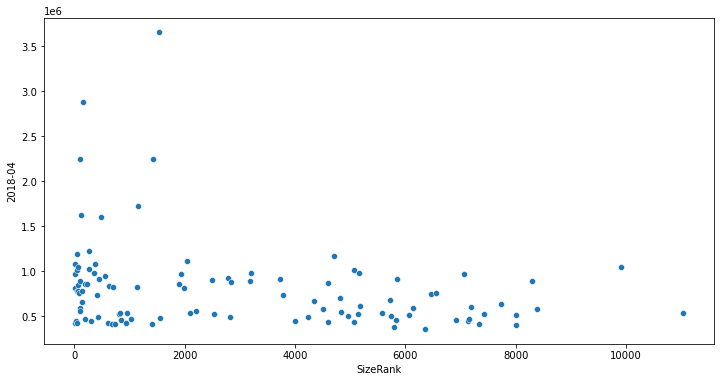

In [10]:
plt.figure(figsize = (12,6))
sns.scatterplot(x = 'SizeRank', y = '2018-04', data = ny_df);

In [7]:
ny_df['3_yr_roi'] = (ny_df['2018-04'] - ny_df['2015-04']) / ny_df['2015-04']

<ipython-input-7-de911f5f8043>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ny_df['3_yr_roi'] = (ny_df['2018-04'] - ny_df['2015-04']) / ny_df['2015-04']


<AxesSubplot:xlabel='CountyName', ylabel='3_yr_roi'>

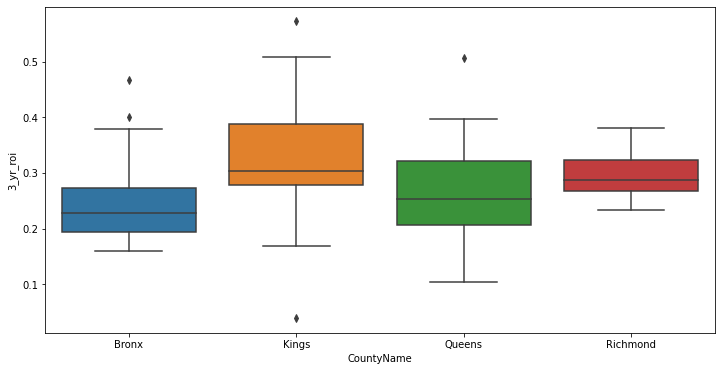

In [13]:
plt.figure(figsize = (12,6))
sns.boxplot(x = 'CountyName', y = '3_yr_roi', data = ny_df)

<AxesSubplot:xlabel='2018-04', ylabel='3_yr_roi'>

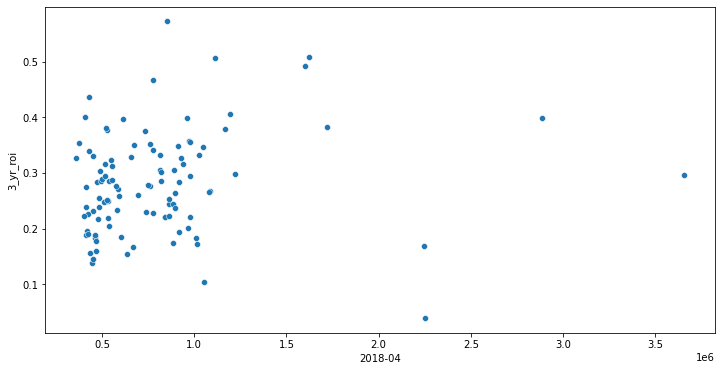

In [9]:
plt.figure(figsize = (12,6))
sns.scatterplot(x = '2018-04', y = '3_yr_roi', data = ny_df)

<AxesSubplot:xlabel='SizeRank', ylabel='3_yr_roi'>

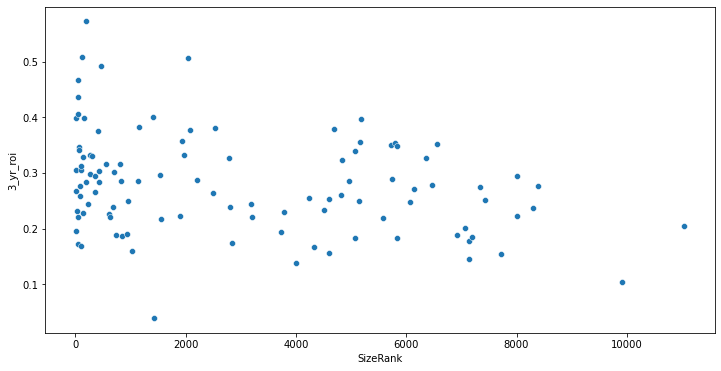

In [10]:
plt.figure(figsize = (12,6))
sns.scatterplot(x = 'SizeRank', y = '3_yr_roi', data = ny_df)

<AxesSubplot:>

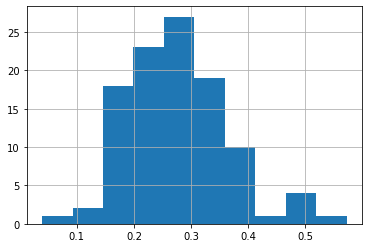

In [11]:
ny_df['3_yr_roi'].hist()

In [12]:
ny_df['3_yr_roi'].describe()

count    106.000000
mean       0.279379
std        0.090118
min        0.039290
25%        0.220862
50%        0.275110
75%        0.331004
max        0.571929
Name: 3_yr_roi, dtype: float64

In [ ]:
ny_df[(ny_df['2018-04'] <= 1500000) & (ny_df['3_yr_roi'] > 0.27)]

In [8]:
ny_df['07_11_roi'] = (ny_df['2011-01'] - ny_df['2007-01']) / ny_df['2007-01']

<ipython-input-8-bd7c3a8cb904>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ny_df['07_11_roi'] = (ny_df['2011-01'] - ny_df['2007-01']) / ny_df['2007-01']


<AxesSubplot:>

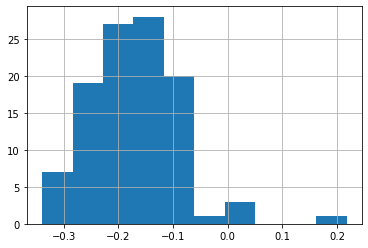

In [13]:
ny_df['07_11_roi'].hist()

In [14]:
ny_df['07_11_roi'].describe()

count    106.000000
mean      -0.170074
std        0.080123
min       -0.339659
25%       -0.224847
50%       -0.170140
75%       -0.118981
max        0.217395
Name: 07_11_roi, dtype: float64

<AxesSubplot:xlabel='CountyName', ylabel='07_11_roi'>

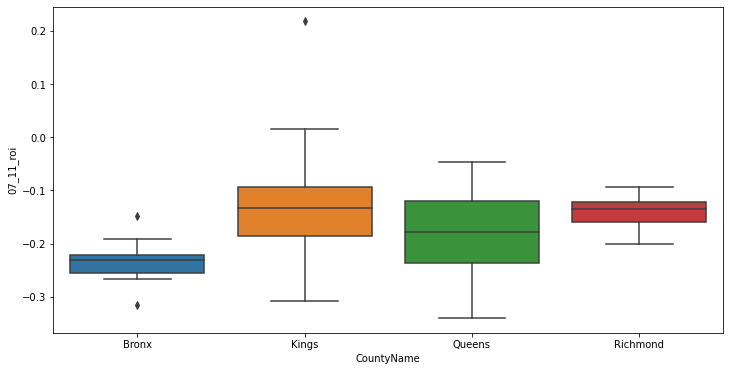

In [10]:
plt.figure(figsize = (12,6))
sns.boxplot(x = 'CountyName', y = '07_11_roi', data = ny_df)

<AxesSubplot:xlabel='2018-04', ylabel='07_11_roi'>

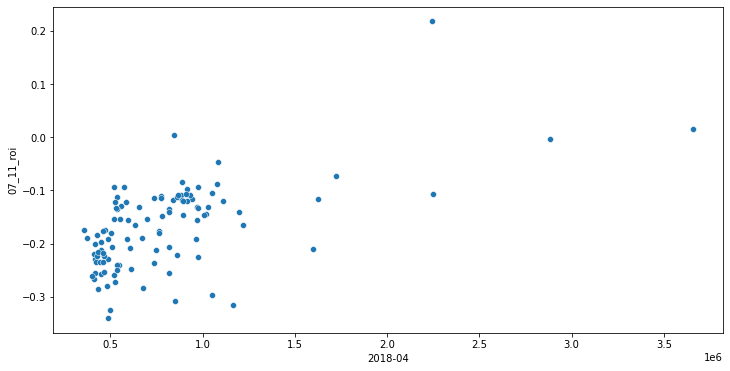

In [28]:
plt.figure(figsize = (12,6))
sns.scatterplot(x = '2018-04', y = '07_11_roi', data = ny_df)

<AxesSubplot:xlabel='07_11_roi', ylabel='3_yr_roi'>

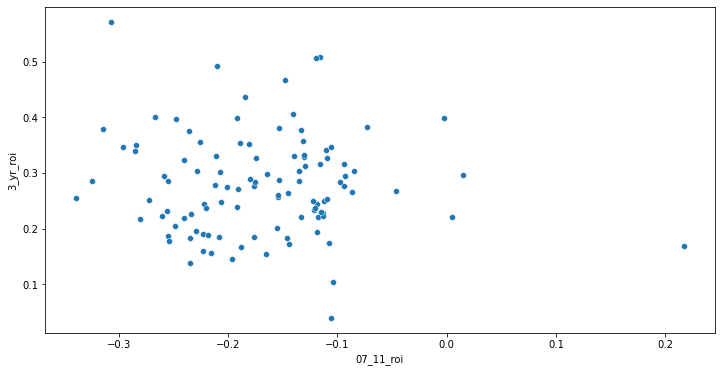

In [11]:
plt.figure(figsize = (12,6))
sns.scatterplot(x = '07_11_roi', y = '3_yr_roi', data = ny_df)

(0.3, 0.6)

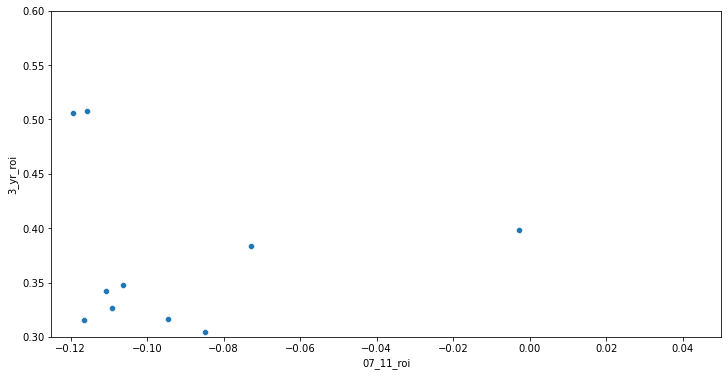

In [11]:
plt.figure(figsize = (12,6))
sns.scatterplot(x = '07_11_roi', y = '3_yr_roi', data = ny_df)
plt.xlim(-0.125, 0.05)
plt.ylim(.30,.60)

In [ ]:
ny_df[(ny_df['07_11_roi'] > -0.125) & (ny_df['3_yr_roi'] > 0.3)].sort_values(by = '3_yr_roi', ascending = False)

In [8]:
top10 = ny_df[(ny_df['07_11_roi'] > -0.125) & (ny_df['3_yr_roi'] > 0.3)].sort_values(by = '3_yr_roi')

In [9]:
top10

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,3_yr_roi,07_11_roi
99,62067,11355,New York,NY,New York,Queens,100,182800.0,182500.0,182300.0,...,853000,859500,865500,871400,875900,877300,882400,890200,0.304322,-0.084823
552,62066,11354,New York,NY,New York,Queens,553,225300.0,226500.0,227800.0,...,892400,903100,911000,916500,923500,929900,935700,941200,0.315628,-0.116371
811,62035,11224,New York,NY,New York,Kings,812,158000.0,157300.0,156700.0,...,490800,494400,496000,498700,502000,505600,511600,517900,0.316472,-0.094418
2790,62008,11105,New York,NY,New York,Queens,2791,185700.0,186300.0,187000.0,...,911800,915900,912800,900800,897900,904900,918000,929200,0.326481,-0.109234
72,62039,11229,New York,NY,New York,Kings,73,183900.0,184200.0,184500.0,...,734500,735500,736100,741000,748100,755800,766200,775500,0.341928,-0.110645
5840,62182,11694,New York,NY,New York,Queens,5841,285700.0,286600.0,287600.0,...,874400,880400,880900,885800,893000,896400,902900,912100,0.347466,-0.106343
1155,62033,11222,New York,NY,New York,Kings,1156,149200.0,148400.0,147500.0,...,1638700,1640400,1644100,1651200,1661800,1672800,1694000,1721100,0.383187,-0.072898
156,62048,11238,New York,NY,New York,Kings,157,NaN,NaN,NaN,...,2716500,2724000,2744300,2768900,2810700,2848100,2869600,2885300,0.398526,-0.002756
2043,62005,11102,New York,NY,New York,Queens,2044,168600.0,169500.0,170400.0,...,1010800,1008000,1027500,1053700,1071500,1072700,1088200,1112100,0.506298,-0.119327
117,62022,11211,New York,NY,New York,Kings,118,133200.0,132900.0,132500.0,...,1424700,1435300,1440500,1463100,1496100,1531100,1581900,1623700,0.507894,-0.115706


In [9]:
top10.drop(['RegionID', 'City', 'State', 'Metro', 'CountyName', 'SizeRank', '3_yr_roi', '07_11_roi'], axis = 1, inplace = True)

In [79]:
top10

,RegionName,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
99,11355,182800.0,182500.0,182300.0,182100.0,181900.0,181800.0,181700.0,181900.0,182300.0,...,842400,847300,853000,859500,865500,871400,875900,877300,882400,890200
552,11354,225300.0,226500.0,227800.0,229200.0,230700.0,232100.0,233500.0,235000.0,236700.0,...,872100,880900,892400,903100,911000,916500,923500,929900,935700,941200
811,11224,158000.0,157300.0,156700.0,156100.0,155600.0,155000.0,154400.0,153700.0,153000.0,...,477800,484900,490800,494400,496000,498700,502000,505600,511600,517900
2790,11105,185700.0,186300.0,187000.0,187800.0,188700.0,189500.0,190300.0,191200.0,192400.0,...,911000,908900,911800,915900,912800,900800,897900,904900,918000,929200
72,11229,183900.0,184200.0,184500.0,184800.0,185000.0,185100.0,185400.0,185600.0,186200.0,...,724100,730300,734500,735500,736100,741000,748100,755800,766200,775500
5840,11694,285700.0,286600.0,287600.0,288600.0,289900.0,291600.0,293400.0,295600.0,298000.0,...,849400,860900,874400,880400,880900,885800,893000,896400,902900,912100
1155,11222,149200.0,148400.0,147500.0,146600.0,146000.0,145600.0,145400.0,145600.0,146100.0,...,1598000,1623800,1638700,1640400,1644100,1651200,1661800,1672800,1694000,1721100
156,11238,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2673300,2696700,2716500,2724000,2744300,2768900,2810700,2848100,2869600,2885300
2043,11102,168600.0,169500.0,170400.0,171400.0,172500.0,173600.0,174700.0,176100.0,177700.0,...,1013200,1015800,1010800,1008000,1027500,1053700,1071500,1072700,1088200,1112100
117,11211,133200.0,132900.0,132500.0,132200.0,131800.0,131600.0,131500.0,131800.0,132400.0,...,1405100,1406400,1424700,1435300,1440500,1463100,1496100,1531100,1581900,1623700


# Reshape from Wide to Long Format

In [10]:
def melt_data(df, zipcode):
    """
    Takes the zillow_data dataset in wide form or a subset of the zillow_dataset.  
    Returns a long-form datetime dataframe 
    with the datetime column names as the index and the values as the 'values' column.

    If more than one row is passes in the wide-form dataset, the values column
    will be the mean of the values from the datetime columns in all of the rows.
    """
    melted = pd.melt(df[df['RegionName'] == zipcode], id_vars=['RegionName'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    melted.drop('RegionName', axis = 1, inplace = True)
    melted.set_index('time', inplace = True)
    return melted

In [11]:
ts_11355 = melt_data(top10, 11355)

In [12]:
ts_11355

,value
time,
1996-04-01,182800.0
1996-05-01,182500.0
1996-06-01,182300.0
1996-07-01,182100.0
1996-08-01,181900.0
...,...
2017-12-01,871400.0
2018-01-01,875900.0
2018-02-01,877300.0


# ARIMA Modeling

Establish baseline

In [13]:
def shifted_rmse(ts):
    shifted_ts = ts.shift()
    prediction = shifted_ts['2017-05-01':].value
    test = ts['2017-05-01':].value
    rmse = np.sqrt(mean_squared_error(test, prediction))
    prediction.plot(label = 'Prediction', legend = True)
    test.plot(label = 'Observed', legend = True);
    print('RMSE: ' + str(rmse))

RMSE: 6087.350271943725


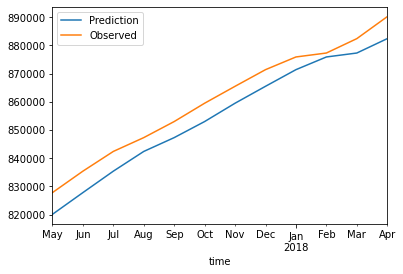

In [14]:
shifted_rmse(ts_11355)

train test split

In [18]:
train_11355 = ts_11355['2011-01':'2017-04']
test_11355 = ts_11355['2017-05':]

In [31]:
train_11355

,value
time,
2011-01-01,522200.0
2011-02-01,523300.0
2011-03-01,523100.0
2011-04-01,524100.0
2011-05-01,527300.0
...,...
2016-12-01,804700.0
2017-01-01,809800.0
2017-02-01,812000.0


In [32]:
test_11355

,value
time,
2017-05-01,827800.0
2017-06-01,835400.0
2017-07-01,842400.0
2017-08-01,847300.0
2017-09-01,853000.0
2017-10-01,859500.0
2017-11-01,865500.0
2017-12-01,871400.0
2018-01-01,875900.0


In [16]:
def stationarity_check(data):
    roll_mean = data.rolling(window = 12, center = False).mean()
    roll_std = data.rolling(window = 12, center = False).std()
    fig = plt.figure(figsize=(12,7))
    plt.plot(data, color='blue', label='Original')
    plt.plot(roll_mean, color='red', label='Rolling Mean')
    plt.plot(roll_std, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    dftest = adfuller(data)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    return dfoutput

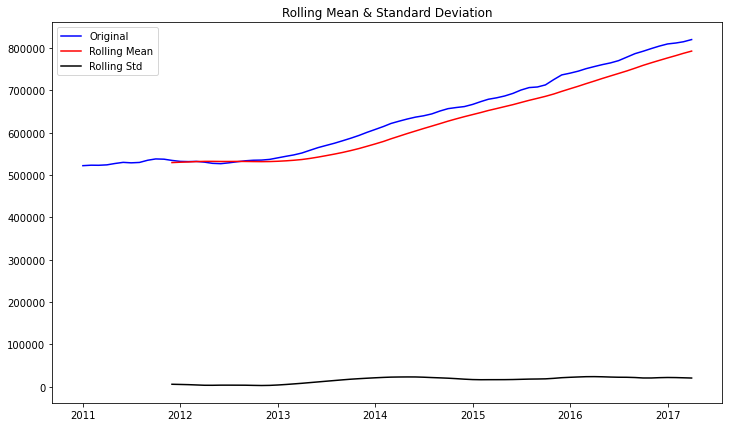

Test Statistic                  0.281953
p-value                         0.976501
#Lags Used                      3.000000
Number of Observations Used    72.000000
Critical Value (1%)            -3.524624
Critical Value (5%)            -2.902607
Critical Value (10%)           -2.588679
dtype: float64

In [19]:
stationarity_check(train_11355)

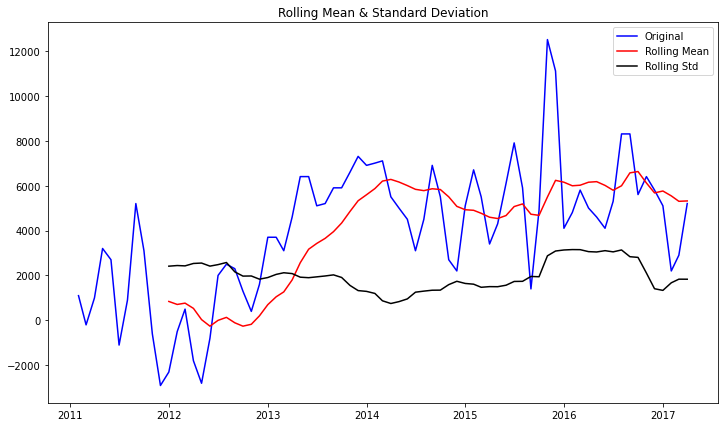

Test Statistic                 -1.781503
p-value                         0.389683
#Lags Used                      2.000000
Number of Observations Used    72.000000
Critical Value (1%)            -3.524624
Critical Value (5%)            -2.902607
Critical Value (10%)           -2.588679
dtype: float64

In [20]:
stationarity_check(train_11355.diff().dropna())

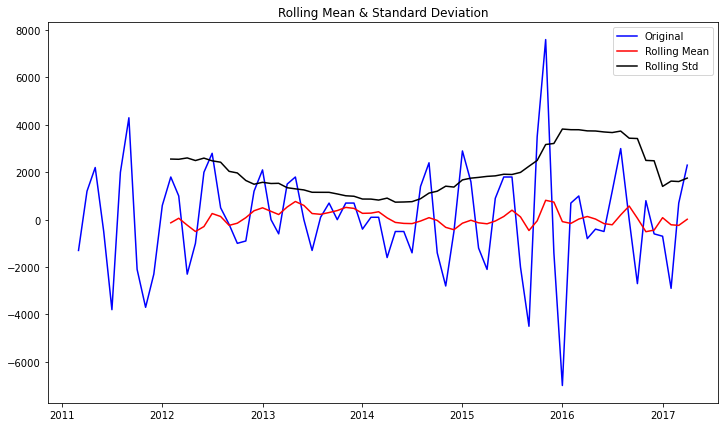

Test Statistic                 -4.666796
p-value                         0.000097
#Lags Used                      6.000000
Number of Observations Used    67.000000
Critical Value (1%)            -3.531955
Critical Value (5%)            -2.905755
Critical Value (10%)           -2.590357
dtype: float64

In [21]:
stationarity_check(train_11355.diff().diff().dropna())

In [18]:
ts_diff = train_11355.diff().diff().dropna()

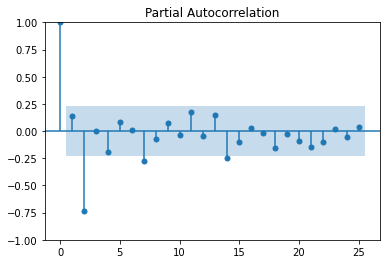

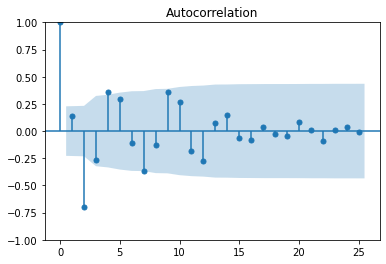

In [19]:
plot_pacf(ts_diff, lags = 25, method = 'ywm');
plot_acf(ts_diff, lags = 25);

In [135]:
from pmdarima.arima.utils import ndiffs





In [138]:
# Or a KPSS test (auto_arima default):
n_kpss = ndiffs(train, test='kpss')  # -> 0
n_kpss

2

In [22]:
model_11355 = auto_arima(train_11355,
                             max_p=2, max_q=2, seasonal = False,
                            trace=True,
                             error_action='ignore',  # don't want to know if an order does not work
                             suppress_warnings=True,  # don't want convergence warnings
                             stepwise=False)  # set to stepwise

                   
model_11355.fit(train_11355)
model_11355.summary()

 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=1348.374, Time=0.07 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=1349.947, Time=0.04 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=1357.159, Time=0.14 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=1349.887, Time=0.05 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=1351.884, Time=0.03 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=1361.805, Time=0.11 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=1381.017, Time=0.08 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=1379.741, Time=0.11 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=1340.323, Time=0.39 sec

Best model:  ARIMA(2,2,2)(0,0,0)[0] intercept
Total fit time: 1.090 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   76
Model:               SARIMAX(2, 2, 2)   Log Likelihood                -664.162
Date:                Tue, 31 Jan 2023   AIC                           1340.323
Time:                        23:00:48   BIC                           1354.147
Sample:                    01-01-2011   HQIC                          1345.838
                         - 04-01-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     52.0193    176.897      0.294      0.769    -294.693     398.732
ar.L1          0.5895      0.012     50.439      0.000       0.567       0.612
ar.L2         -0.9693      0.010    -96.844      0.000      -0.989      -0.950
ma.L1         -0.5963      0.012    -48.143      0.000      -0.621      -0.572
ma.L2          0.9661      0.011     89.624      0.000       0.945       0.987
sigma2      1.937e+06      0.013   1.46e+08      0.000    1.94e+06    1.94e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.55   Jarque-Bera (JB):                15.83
Prob(Q):                              0.46   Prob(JB):                         0.00
Heteroskedasticity (H):               3.55   Skew:                            -0.06
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.26
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.78e+24. Standard errors may be unstable.
"""

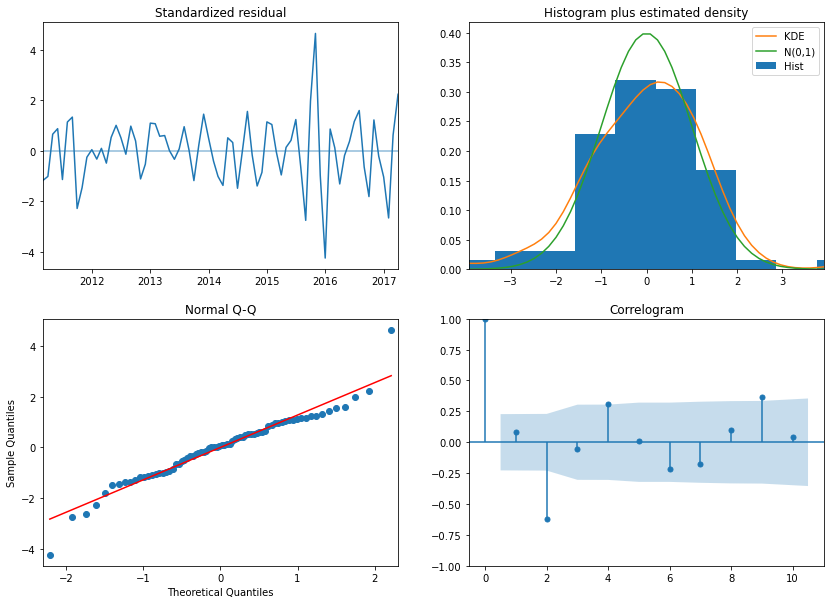

In [118]:
model_11355.plot_diagnostics(figsize=(14,10));

In [23]:
prediction, confint = model_11355.predict(n_periods=12, return_conf_int=True)

prediction 

2017-05-01    825012.940460
2017-06-01    830583.661601
2017-07-01    836872.373338
2017-08-01    842998.765681
2017-09-01    848385.573121
2017-10-01    853545.775958
2017-11-01    859341.278394
2017-12-01    865782.922865
2018-01-01    872041.686348
2018-02-01    877618.385072
2018-03-01    883022.314570
2018-04-01    889037.525079
Freq: MS, dtype: float64

4310.58573936286

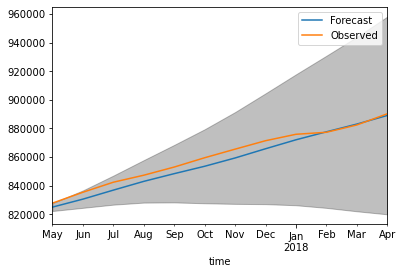

In [32]:
fig, ax = plt.subplots()
prediction.plot(label = 'Forecast', legend = True, ax = ax)
test_11355.plot(y = 'value', label = 'Observed', legend = True, ax=ax)
ax.fill_between(prediction.index,
                confint[:,0],
                confint[:,1], color='k', alpha=0.25);
    
np.sqrt(mean_squared_error(test_11355, prediction))

In [98]:
model_results = pd.DataFrame(columns=['Zipcode', 'base_rmse', 'forecast_rmse'])

In [99]:
model_results = model_results.append({'Zipcode': '11355',
                                      'base_rmse': 6087.35,
                                      'forecast_rmse': 4310.58}, ignore_index = True)

In [35]:
def split(df, zipcode):
    ts = melt_data(df, zipcode)
    train = ts['2011-01':'2017-04']
    test = ts['2017-05':]
    return ts, train, test

In [36]:
def aa_model(train, p, q):
    model = auto_arima(train,
                             max_p=p, max_q=q, seasonal = False,
                       start_p = 0, start_q = 0,
                            trace=True,
                             error_action='ignore',  # don't want to know if an order does not work
                             suppress_warnings=True,  # don't want convergence warnings
                             stepwise=False)  # set to stepwise
    model.fit(train)
    display(model.summary())
    model.plot_diagnostics(figsize = (14,10));
    return model

In [45]:
def forecast_rmse(model, test):
    prediction, confint = model.predict(n_periods=12, return_conf_int=True)
    
    fig, ax = plt.subplots()
    
    prediction.plot(label = 'Forecast', legend = True, ax = ax)
    test.plot(y = 'value', label = 'Observed', legend = True, ax = ax)
    ax.fill_between(prediction.index,
                confint[:,0],
                confint[:,1], color='k', alpha=0.25);
    
    rmse = np.sqrt(mean_squared_error(test, prediction))
    
    print('RMSE: ' + str(rmse))

## 11354

In [38]:
ts_11354, train_11354, test_11354 = split(top10, 11354)

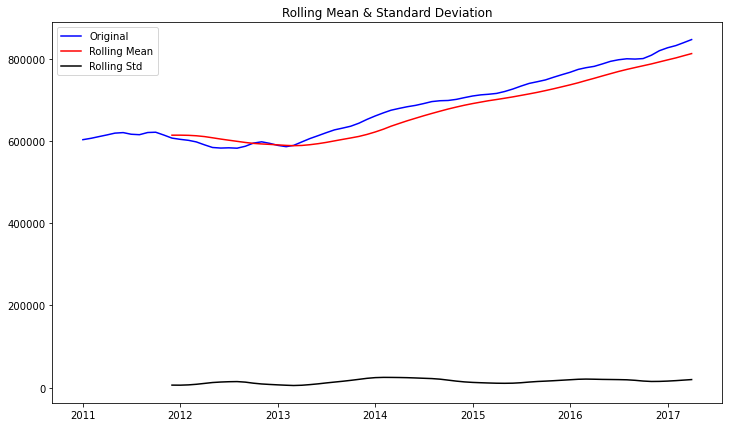

Test Statistic                  1.113323
p-value                         0.995329
#Lags Used                     12.000000
Number of Observations Used    63.000000
Critical Value (1%)            -3.538695
Critical Value (5%)            -2.908645
Critical Value (10%)           -2.591897
dtype: float64

In [20]:
stationarity_check(train_11354)

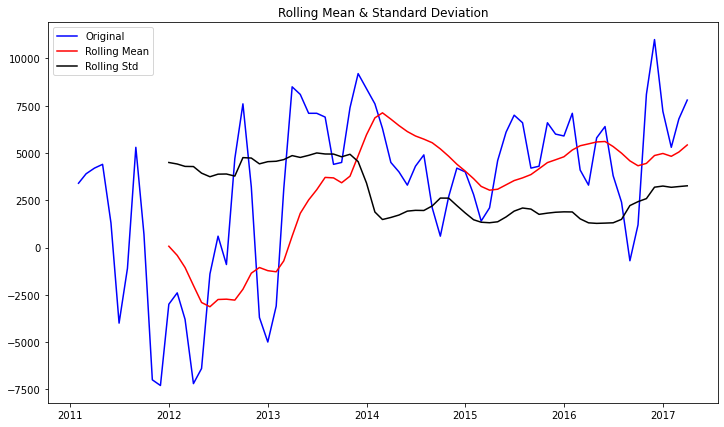

Test Statistic                 -1.995294
p-value                         0.288640
#Lags Used                      8.000000
Number of Observations Used    66.000000
Critical Value (1%)            -3.533560
Critical Value (5%)            -2.906444
Critical Value (10%)           -2.590724
dtype: float64

In [21]:
stationarity_check(train_11354.diff().dropna())

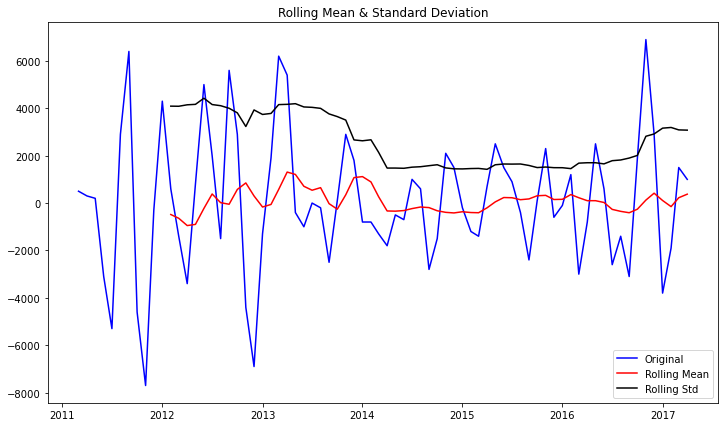

Test Statistic                 -3.514580
p-value                         0.007620
#Lags Used                      9.000000
Number of Observations Used    64.000000
Critical Value (1%)            -3.536928
Critical Value (5%)            -2.907887
Critical Value (10%)           -2.591493
dtype: float64

In [22]:
stationarity_check(train_11354.diff().diff().dropna())

In [39]:
ts_diff = train_11354.diff().diff().dropna()

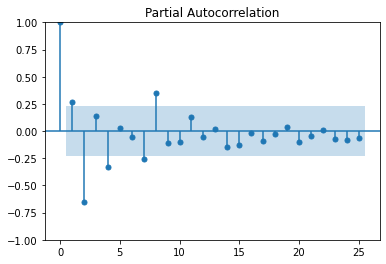

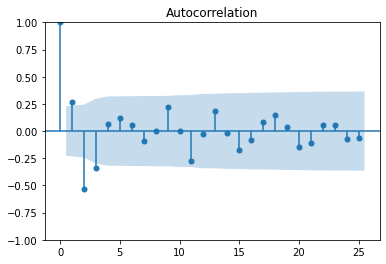

In [40]:
plot_pacf(ts_diff, lags = 25, method = 'ywm');
plot_acf(ts_diff, lags = 25);

 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=1390.923, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=1393.631, Time=0.05 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=1403.411, Time=0.05 sec
 ARIMA(0,2,3)(0,0,0)[0] intercept   : AIC=1444.728, Time=0.09 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=1393.074, Time=0.05 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=1395.645, Time=0.06 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=1414.525, Time=0.17 sec
 ARIMA(1,2,3)(0,0,0)[0] intercept   : AIC=1446.127, Time=0.08 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=1412.105, Time=0.07 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=1415.628, Time=0.08 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=1437.033, Time=0.43 sec
 ARIMA(2,2,3)(0,0,0)[0] intercept   : AIC=1440.051, Time=0.33 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=1414.288, Time=0.05 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=1417.290, Time=0.06 sec
 ARIMA(3,2,2)(0,0,0)[0] intercept   : AIC=1386.880, Time=0.40 sec
 ARIMA(4,2

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   76
Model:               SARIMAX(3, 2, 2)   Log Likelihood                -686.440
Date:                Wed, 01 Feb 2023   AIC                           1386.880
Time:                        02:18:42   BIC                           1403.009
Sample:                    01-01-2011   HQIC                          1393.314
                         - 04-01-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    104.4509    276.908      0.377      0.706    -438.278     647.180
ar.L1          0.3142      0.028     11.167      0.000       0.259       0.369
ar.L2         -0.9222      0.018    -51.126      0.000      -0.958      -0.887
ar.L3          0.0019      0.009      0.215      0.829      -0.016       0.020
ma.L1         -0.3200      0.026    -12.234      0.000      -0.371      -0.269
ma.L2          0.9158      0.018     49.687      0.000       0.880       0.952
sigma2      3.362e+06      0.053   6.36e+07      0.000    3.36e+06    3.36e+06
===================================================================================
Ljung-Box (L1) (Q):                   7.26   Jarque-Bera (JB):                 2.40
Prob(Q):                              0.01   Prob(JB):                         0.30
Heteroskedasticity (H):               0.67   Skew:                             0.37
Prob(H) (two-sided):                  0.32   Kurtosis:                         3.48
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.99e+23. Standard errors may be unstable.
"""

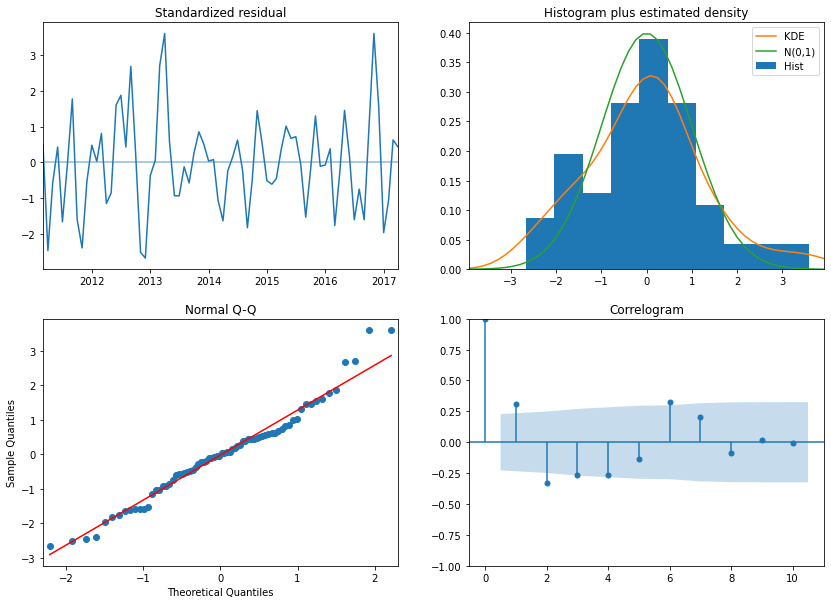

In [41]:
model_11354 = aa_model(train_11354, 4, 3)

RMSE: 5819.318384738266


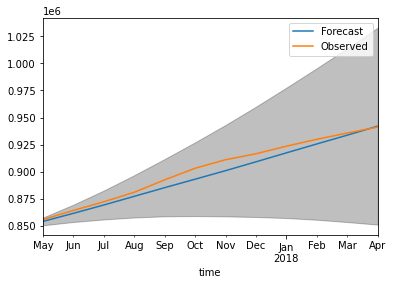

In [46]:
forecast_rmse(model_11354, test_11354)

RMSE: 8132.291599953033


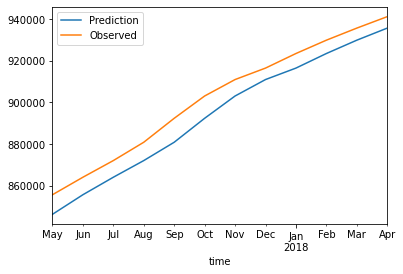

In [47]:
shifted_rmse(ts_11354)

In [100]:
model_results = model_results.append({'Zipcode': '11354',
                                      'forecast_rmse': 5819.31,
                                      'base_rmse': 8132.29}, ignore_index = True)

## 11224

In [48]:
ts_11224, train_11224, test_11224 = split(top10, 11224)

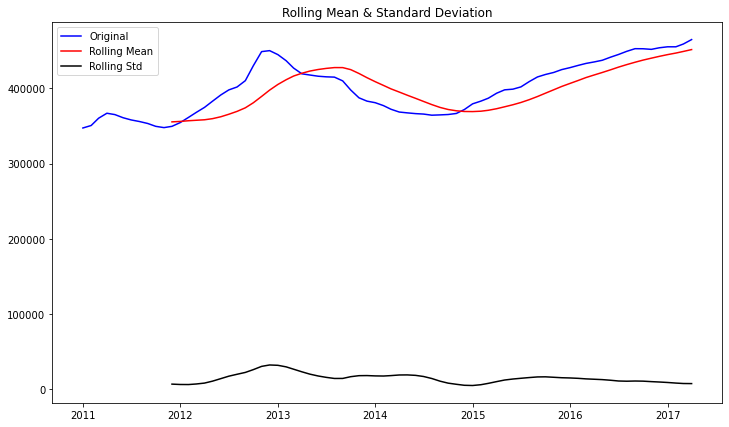

Test Statistic                 -2.127971
p-value                         0.233417
#Lags Used                      9.000000
Number of Observations Used    66.000000
Critical Value (1%)            -3.533560
Critical Value (5%)            -2.906444
Critical Value (10%)           -2.590724
dtype: float64

In [85]:
stationarity_check(train_11224)

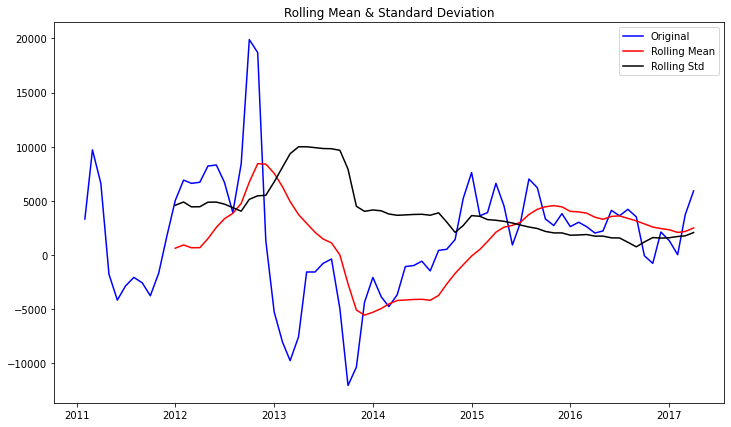

Test Statistic                 -2.892300
p-value                         0.046251
#Lags Used                     10.000000
Number of Observations Used    64.000000
Critical Value (1%)            -3.536928
Critical Value (5%)            -2.907887
Critical Value (10%)           -2.591493
dtype: float64

In [86]:
stationarity_check(train_11224.diff().dropna())

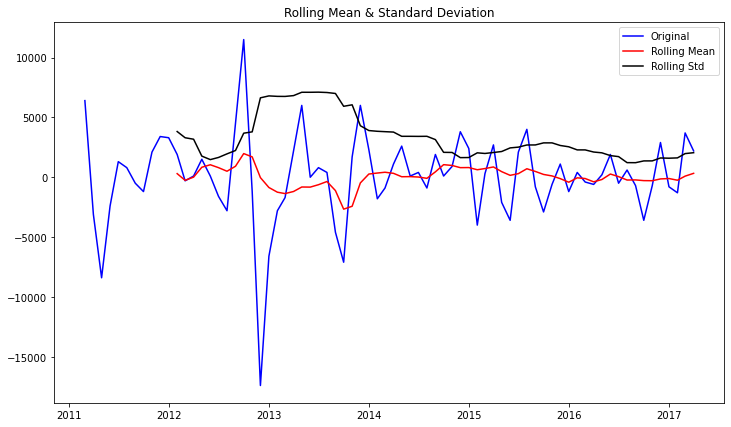

Test Statistic                 -3.165678
p-value                         0.022059
#Lags Used                      7.000000
Number of Observations Used    66.000000
Critical Value (1%)            -3.533560
Critical Value (5%)            -2.906444
Critical Value (10%)           -2.590724
dtype: float64

In [89]:
stationarity_check(train_11224.diff().diff().dropna())

In [87]:
ts_diff = train_11224.diff().dropna()

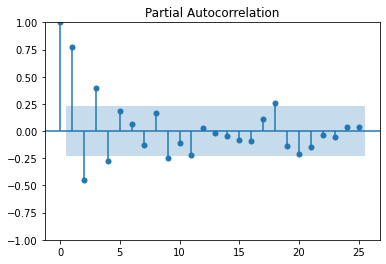

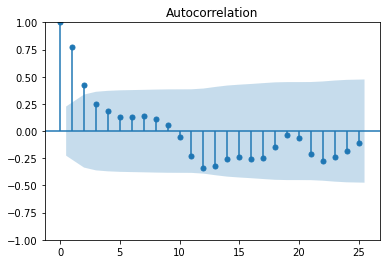

In [88]:
plot_pacf(ts_diff, lags = 25, method = 'ywm');
plot_acf(ts_diff, lags = 25);

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1508.731, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1509.564, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1559.872, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1510.238, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1649.210, Time=0.09 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1583.591, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1621.269, Time=0.15 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1645.534, Time=0.12 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=1619.762, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1510.711, Time=0.22 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1627.875, Time=0.25 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=1510.210, Time=0.20 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=1625.400, Time=0.26 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 1.830 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   76
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -752.365
Date:                Wed, 01 Feb 2023   AIC                           1508.731
Time:                        02:32:15   BIC                           1513.366
Sample:                    01-01-2011   HQIC                          1510.581
                         - 04-01-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1566.6667    647.333      2.420      0.016     297.917    2835.416
sigma2      3.026e+07   3.74e+06      8.093      0.000    2.29e+07    3.76e+07
===================================================================================
Ljung-Box (L1) (Q):                  46.82   Jarque-Bera (JB):                 9.98
Prob(Q):                              0.00   Prob(JB):                         0.01
Heteroskedasticity (H):               0.12   Skew:                             0.37
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

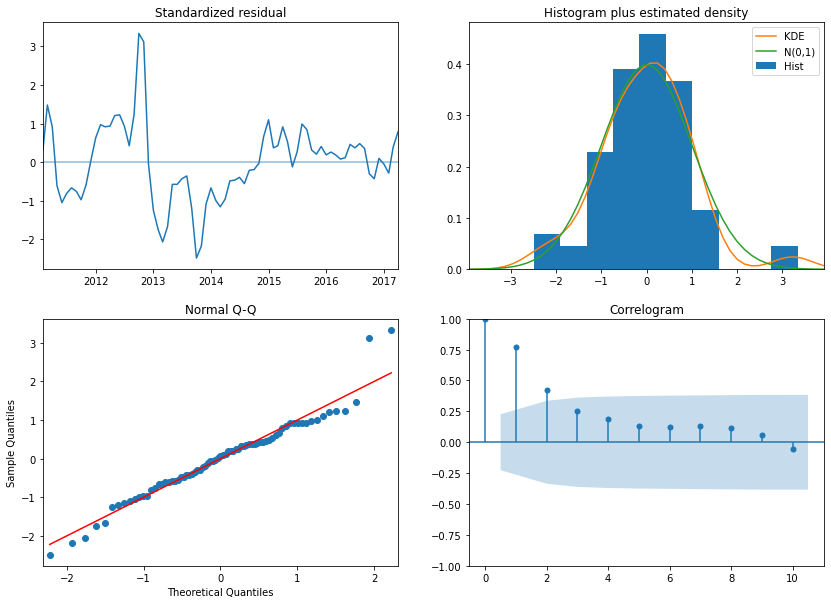

In [49]:
model_11224 = aa_model(train_11224, 4, 2)

RMSE: 20700.02460188182


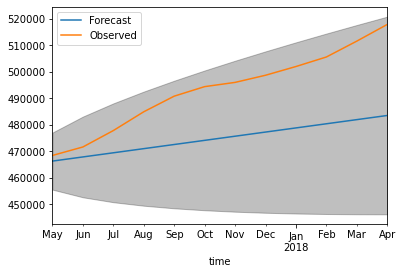

In [51]:
forecast_rmse(model_11224, test_11224)

RMSE: 4742.889414692272


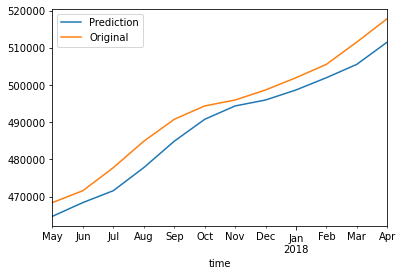

In [93]:
shifted_rmse(ts_11224)

In [101]:
model_results = model_results.append({'Zipcode': '11224',
                                      'forecast_rmse': 20700.02,
                                      'base_rmse': 4742.88}, ignore_index = True)

## 11105

In [52]:
ts_11105, train_11105, test_11105 = split(top10, 11105)

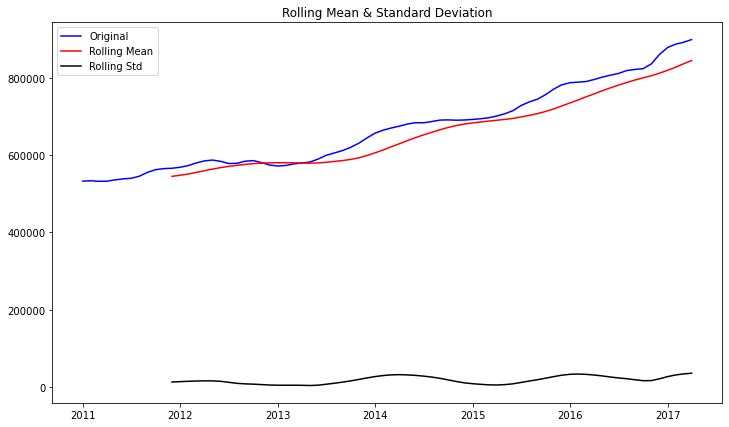

Test Statistic                  3.443588
p-value                         1.000000
#Lags Used                     10.000000
Number of Observations Used    65.000000
Critical Value (1%)            -3.535217
Critical Value (5%)            -2.907154
Critical Value (10%)           -2.591103
dtype: float64

In [95]:
stationarity_check(train_11105)

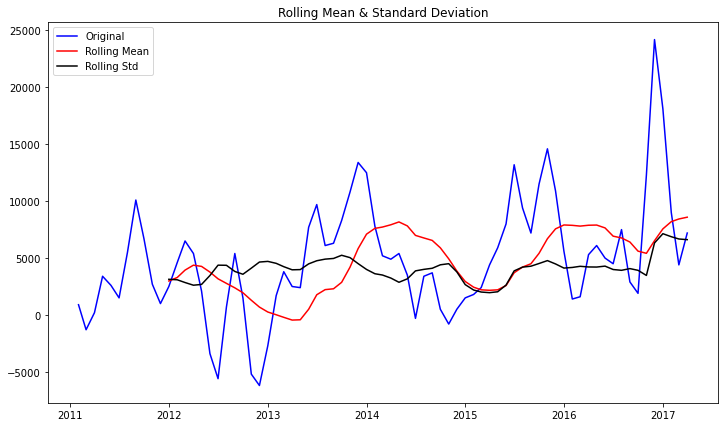

Test Statistic                 -2.318077
p-value                         0.166204
#Lags Used                      2.000000
Number of Observations Used    72.000000
Critical Value (1%)            -3.524624
Critical Value (5%)            -2.902607
Critical Value (10%)           -2.588679
dtype: float64

In [97]:
stationarity_check(train_11105.diff().dropna())

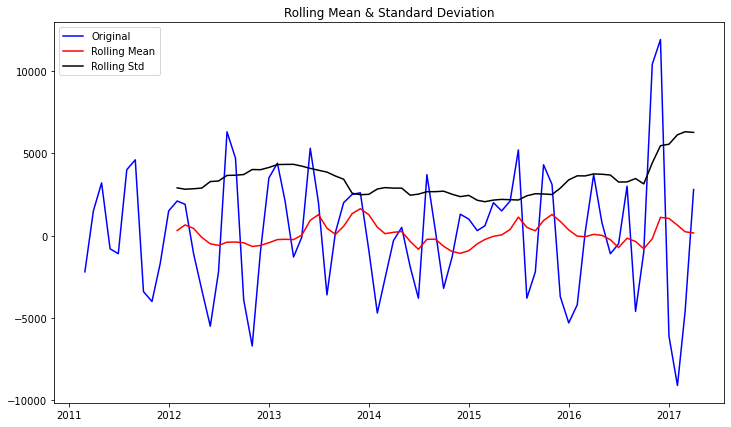

Test Statistic                 -4.676751
p-value                         0.000093
#Lags Used                     11.000000
Number of Observations Used    62.000000
Critical Value (1%)            -3.540523
Critical Value (5%)            -2.909427
Critical Value (10%)           -2.592314
dtype: float64

In [98]:
stationarity_check(train_11105.diff().diff().dropna())

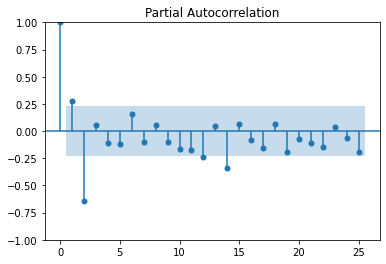

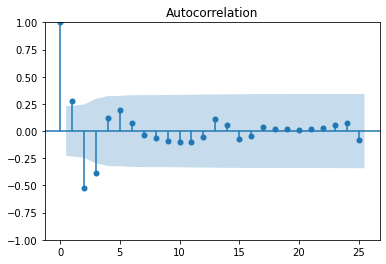

In [99]:
ts_diff = train_11105.diff().diff().dropna()



plot_pacf(ts_diff, lags = 25, method = 'ywm');
plot_acf(ts_diff, lags = 25);

 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=1431.469, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=1433.402, Time=0.04 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,2,3)(0,0,0)[0] intercept   : AIC=1442.278, Time=0.08 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=1433.017, Time=0.05 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=1435.325, Time=0.11 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=1440.374, Time=0.12 sec
 ARIMA(1,2,3)(0,0,0)[0] intercept   : AIC=1444.443, Time=0.32 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=1453.903, Time=0.04 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=1436.512, Time=0.23 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=1442.972, Time=0.30 sec
 ARIMA(2,2,3)(0,0,0)[0] intercept   : AIC=1453.516, Time=0.25 sec

Best model:  ARIMA(0,2,0)(0,0,0)[0] intercept
Total fit time: 1.660 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   76
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -713.734
Date:                Wed, 01 Feb 2023   AIC                           1431.469
Time:                        02:32:51   BIC                           1436.077
Sample:                    01-01-2011   HQIC                          1433.307
                         - 04-01-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     85.1351    445.565      0.191      0.848    -788.156     958.426
sigma2      1.397e+07   2.04e+06      6.832      0.000    9.96e+06     1.8e+07
===================================================================================
Ljung-Box (L1) (Q):                   5.94   Jarque-Bera (JB):                 2.93
Prob(Q):                              0.01   Prob(JB):                         0.23
Heteroskedasticity (H):               1.95   Skew:                             0.36
Prob(H) (two-sided):                  0.10   Kurtosis:                         3.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

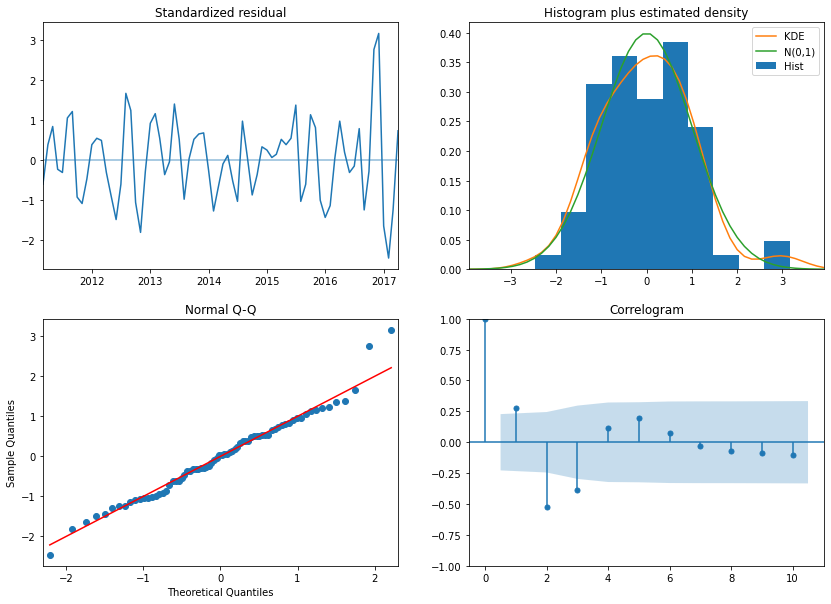

In [53]:
model_11105 = aa_model(train_11105, 2, 3)

RMSE: 45008.30341986746


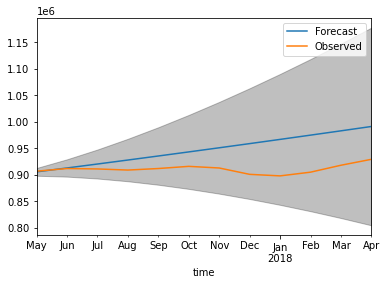

In [54]:
forecast_rmse(model_11105, test_11105)

RMSE: 7287.546454969144


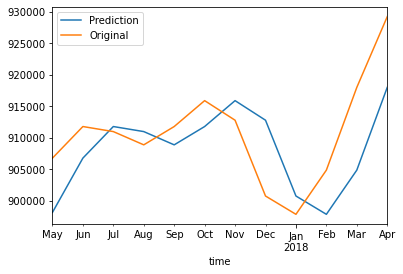

In [96]:
shifted_rmse(ts_11105)

In [102]:
model_results = model_results.append({'Zipcode': '11105',
                                      'forecast_rmse': 45008.30,
                                      'base_rmse': 7287.54}, ignore_index = True)

## 11229

In [55]:
ts_11229, train_11229, test_11229 = split(top10, 11229)

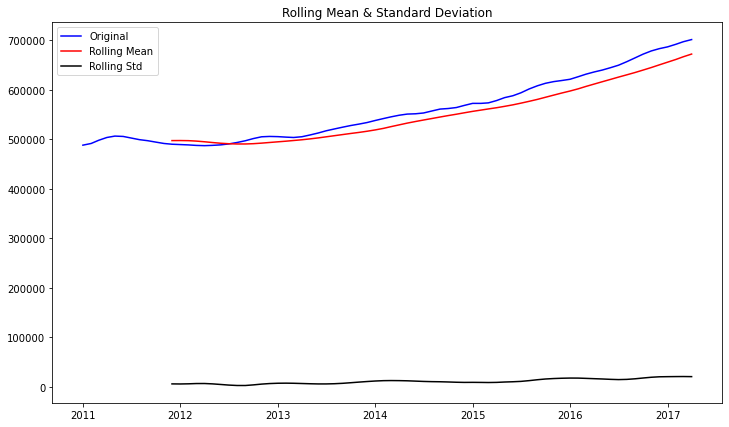

Test Statistic                  1.571894
p-value                         0.997771
#Lags Used                      6.000000
Number of Observations Used    69.000000
Critical Value (1%)            -3.528890
Critical Value (5%)            -2.904440
Critical Value (10%)           -2.589656
dtype: float64

In [121]:
stationarity_check(train_11229)

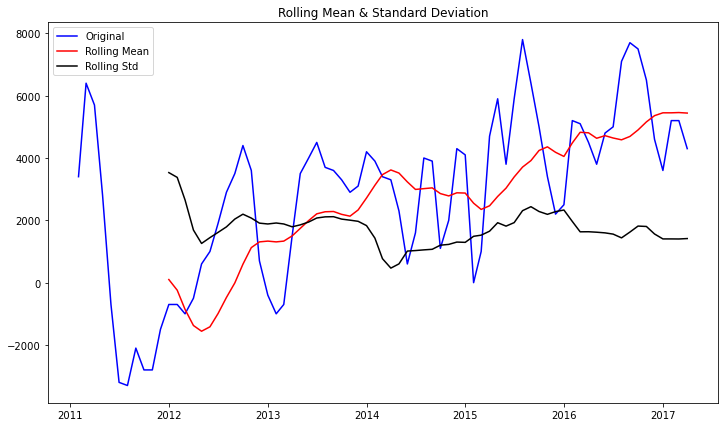

Test Statistic                 -1.759674
p-value                         0.400658
#Lags Used                      5.000000
Number of Observations Used    69.000000
Critical Value (1%)            -3.528890
Critical Value (5%)            -2.904440
Critical Value (10%)           -2.589656
dtype: float64

In [123]:
stationarity_check(train_11229.diff().dropna())

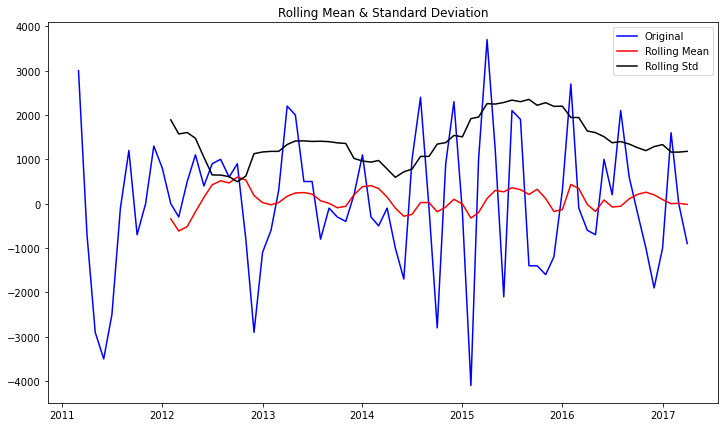

Test Statistic                 -4.486299
p-value                         0.000208
#Lags Used                     11.000000
Number of Observations Used    62.000000
Critical Value (1%)            -3.540523
Critical Value (5%)            -2.909427
Critical Value (10%)           -2.592314
dtype: float64

In [124]:
stationarity_check(train_11229.diff().diff().dropna())

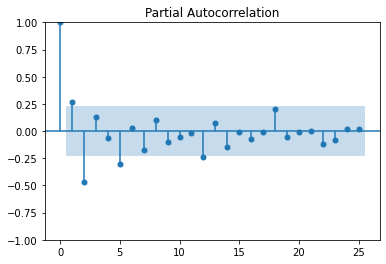

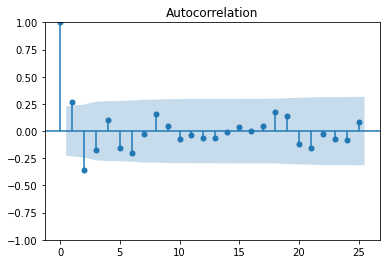

In [125]:
ts_diff = train_11229.diff().diff().dropna()



plot_pacf(ts_diff, lags = 25, method = 'ywm');
plot_acf(ts_diff, lags = 25);

 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=1297.418, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=1298.959, Time=0.08 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=1302.121, Time=0.06 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=1296.006, Time=0.05 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=1301.592, Time=0.11 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=1299.703, Time=0.13 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=1302.963, Time=0.04 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=1300.230, Time=0.13 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=1296.471, Time=0.26 sec

Best model:  ARIMA(1,2,0)(0,0,0)[0] intercept
Total fit time: 0.890 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   76
Model:               SARIMAX(1, 2, 0)   Log Likelihood                -645.003
Date:                Wed, 01 Feb 2023   AIC                           1296.006
Time:                        02:33:22   BIC                           1302.918
Sample:                    01-01-2011   HQIC                          1298.764
                         - 04-01-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    -35.3699    162.346     -0.218      0.828    -353.561     282.822
ar.L1         -0.0107      0.041     -0.263      0.792      -0.091       0.069
sigma2      2.025e+06      3e+05      6.758      0.000    1.44e+06    2.61e+06
===================================================================================
Ljung-Box (L1) (Q):                   6.85   Jarque-Bera (JB):                 1.30
Prob(Q):                              0.01   Prob(JB):                         0.52
Heteroskedasticity (H):               1.25   Skew:                            -0.28
Prob(H) (two-sided):                  0.58   Kurtosis:                         3.32
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

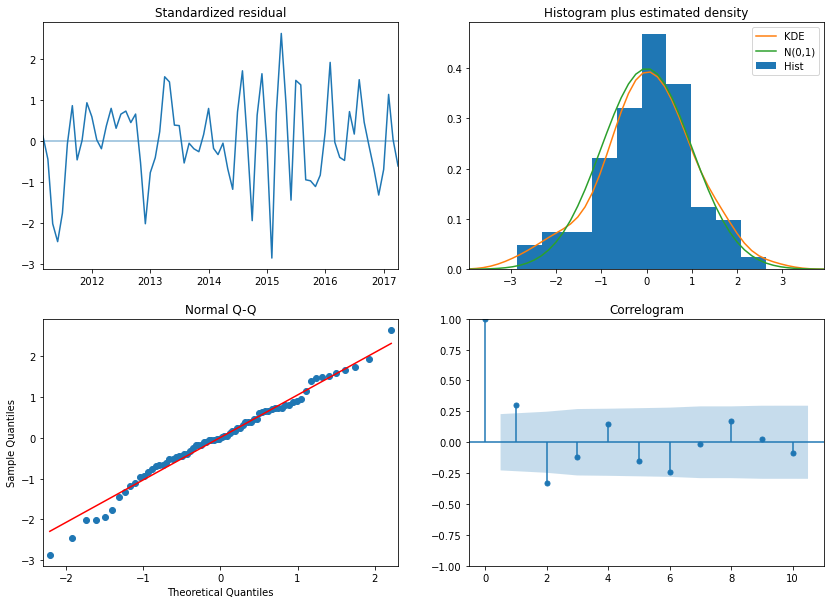

In [56]:
model_11229 = aa_model(train_11229, 2, 2)

RMSE: 12927.983876116234


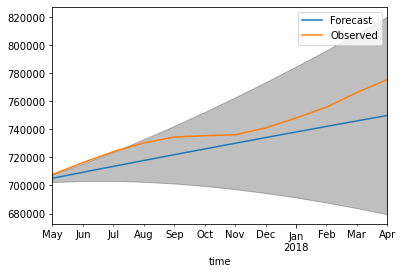

In [57]:
forecast_rmse(model_11229, test_11229)

RMSE: 6870.8320699412625


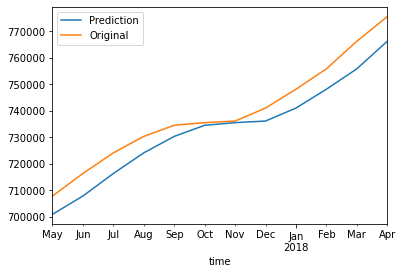

In [132]:
shifted_rmse(ts_11229)

In [103]:
model_results = model_results.append({'Zipcode': '11229',
                                      'forecast_rmse': 12927.98,
                                      'base_rmse': 6870.83}, ignore_index = True)

## 11694

In [58]:
ts_11694, train_11694, test_11694 = split(top10, 11694)

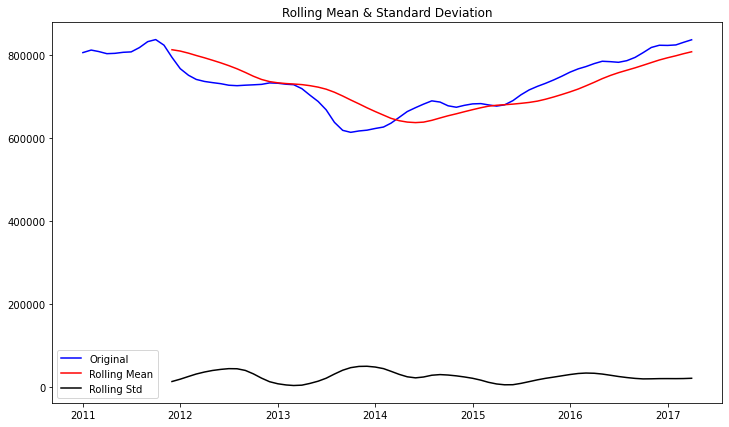

Test Statistic                 -1.679355
p-value                         0.441779
#Lags Used                      8.000000
Number of Observations Used    67.000000
Critical Value (1%)            -3.531955
Critical Value (5%)            -2.905755
Critical Value (10%)           -2.590357
dtype: float64

In [135]:
stationarity_check(train_11694)

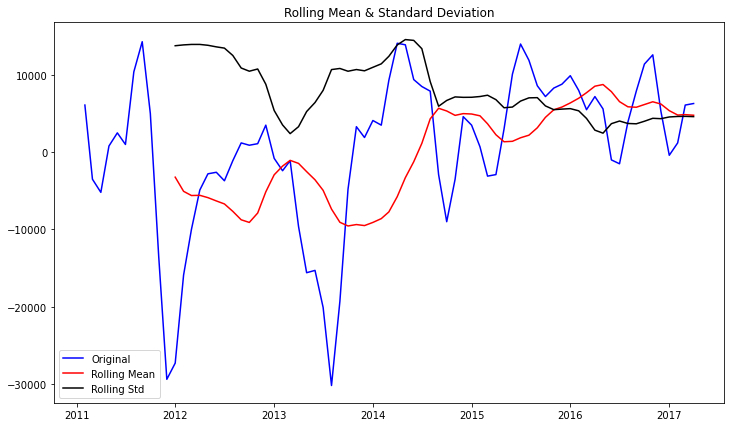

Test Statistic                 -2.328910
p-value                         0.162813
#Lags Used                      7.000000
Number of Observations Used    67.000000
Critical Value (1%)            -3.531955
Critical Value (5%)            -2.905755
Critical Value (10%)           -2.590357
dtype: float64

In [136]:
stationarity_check(train_11694.diff().dropna())

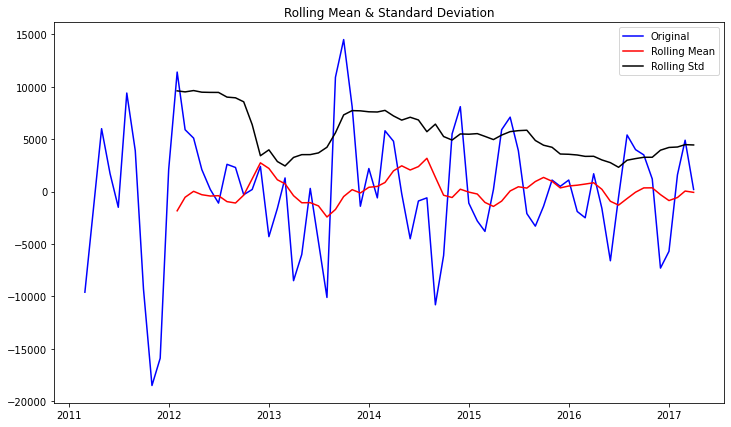

Test Statistic                 -5.043044
p-value                         0.000018
#Lags Used                     11.000000
Number of Observations Used    62.000000
Critical Value (1%)            -3.540523
Critical Value (5%)            -2.909427
Critical Value (10%)           -2.592314
dtype: float64

In [137]:
stationarity_check(train_11694.diff().diff().dropna())

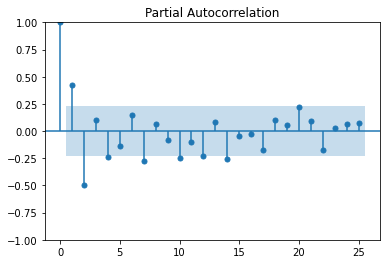

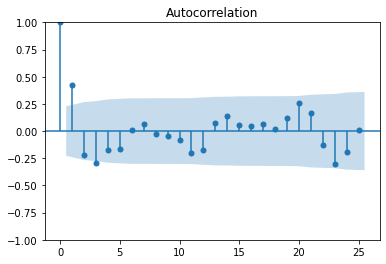

In [138]:
ts_diff = train_11694.diff().diff().dropna()



plot_pacf(ts_diff, lags = 25, method = 'ywm');
plot_acf(ts_diff, lags = 25);

 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=1496.834, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=1499.385, Time=0.04 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=1496.432, Time=0.05 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=1501.290, Time=0.18 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=1507.263, Time=0.04 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=1508.602, Time=0.18 sec

Best model:  ARIMA(1,2,0)(0,0,0)[0] intercept
Total fit time: 0.530 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   76
Model:               SARIMAX(1, 2, 0)   Log Likelihood                -745.216
Date:                Wed, 01 Feb 2023   AIC                           1496.432
Time:                        02:34:48   BIC                           1503.344
Sample:                    01-01-2011   HQIC                          1499.190
                         - 04-01-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    134.2466    552.947      0.243      0.808    -949.509    1218.003
ar.L1          0.0149      0.024      0.619      0.536      -0.032       0.062
sigma2      2.674e+07      0.025   1.06e+09      0.000    2.67e+07    2.67e+07
===================================================================================
Ljung-Box (L1) (Q):                  14.15   Jarque-Bera (JB):                 7.97
Prob(Q):                              0.00   Prob(JB):                         0.02
Heteroskedasticity (H):               0.33   Skew:                            -0.50
Prob(H) (two-sided):                  0.01   Kurtosis:                         4.26
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 9.25e+25. Standard errors may be unstable.
"""

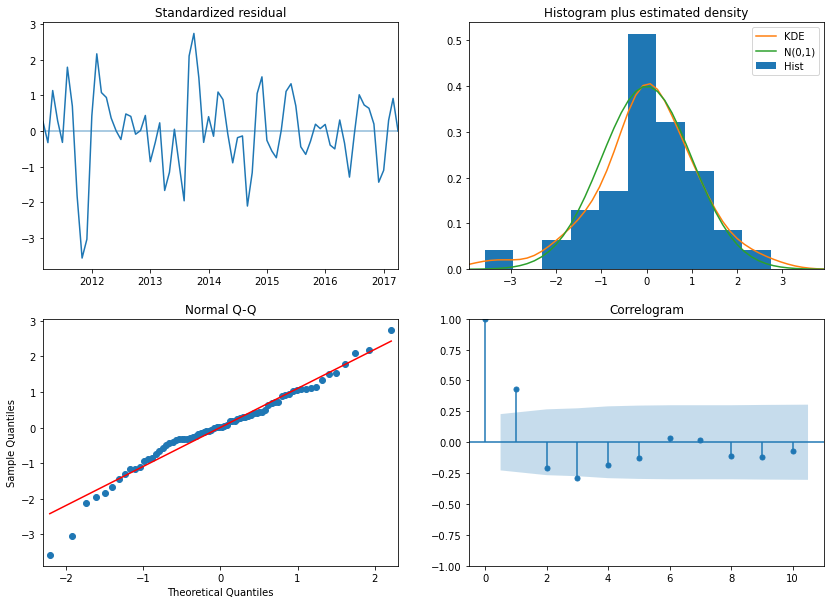

In [59]:
model_11694 = aa_model(train_11694, 2, 1)

RMSE: 7075.3236760500495


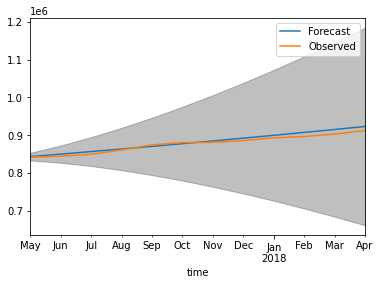

In [60]:
forecast_rmse(model_11694, test_11694)

RMSE: 7198.553095356501


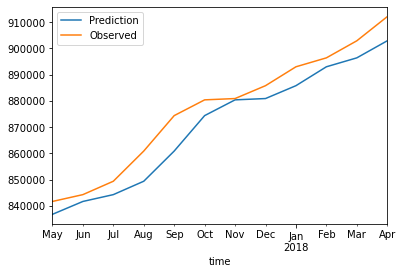

In [61]:
shifted_rmse(ts_11694)

In [104]:
model_results = model_results.append({'Zipcode': '11694',
                                      'forecast_rmse': 7075.32,
                                      'base_rmse': 7198.55}, ignore_index = True)

## 11222

In [62]:
ts_11222, train_11222, test_11222 = split(top10, 11222)

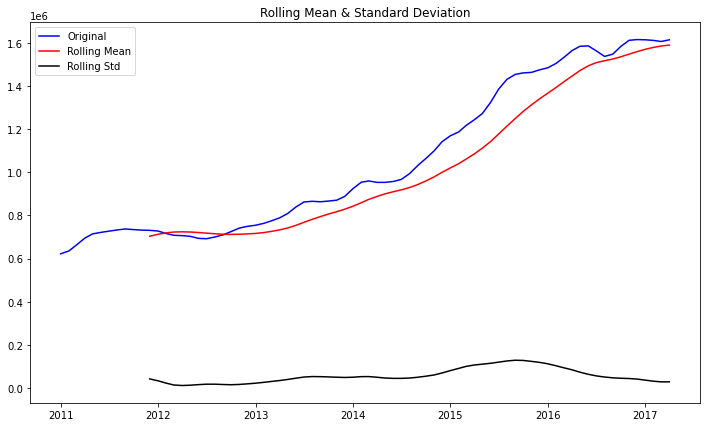

Test Statistic                  0.748843
p-value                         0.990764
#Lags Used                     12.000000
Number of Observations Used    63.000000
Critical Value (1%)            -3.538695
Critical Value (5%)            -2.908645
Critical Value (10%)           -2.591897
dtype: float64

In [142]:
stationarity_check(train_11222)

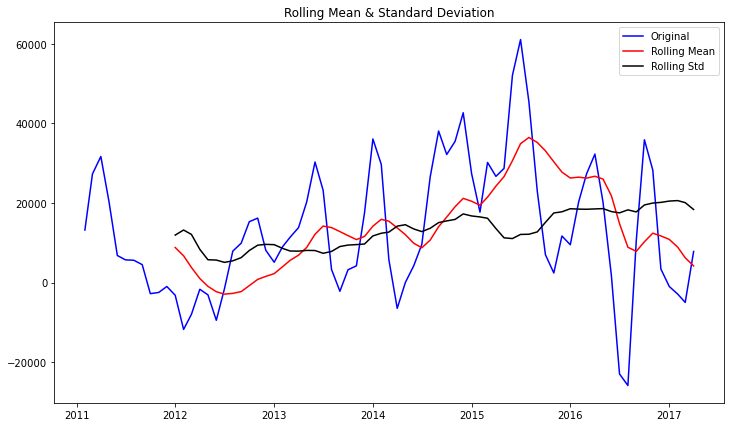

Test Statistic                 -3.106451
p-value                         0.026079
#Lags Used                     11.000000
Number of Observations Used    63.000000
Critical Value (1%)            -3.538695
Critical Value (5%)            -2.908645
Critical Value (10%)           -2.591897
dtype: float64

In [143]:
stationarity_check(train_11222.diff().dropna())

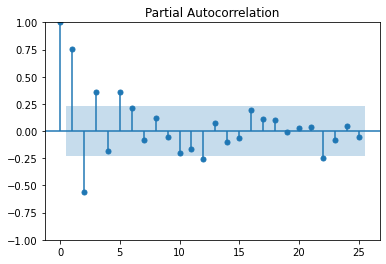

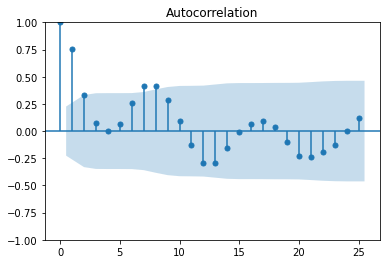

In [157]:
ts_diff = train_11222.diff().dropna()



plot_pacf(ts_diff, lags = 25, method = 'ywm');
plot_acf(ts_diff, lags = 25);

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1674.225, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1692.738, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1675.254, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1755.878, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1777.955, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1773.986, Time=0.11 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1791.161, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1779.611, Time=0.11 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1796.832, Time=0.17 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=1833.678, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1780.977, Time=0.13 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1802.738, Time=0.22 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 1.200 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   76
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -835.113
Date:                Wed, 01 Feb 2023   AIC                           1674.225
Time:                        02:35:32   BIC                           1678.860
Sample:                    01-01-2011   HQIC                          1676.076
                         - 04-01-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1.324e+04   1981.170      6.684      0.000    9359.645    1.71e+04
sigma2      2.749e+08   4.57e+07      6.010      0.000    1.85e+08    3.64e+08
===================================================================================
Ljung-Box (L1) (Q):                  44.74   Jarque-Bera (JB):                 1.72
Prob(Q):                              0.00   Prob(JB):                         0.42
Heteroskedasticity (H):               2.54   Skew:                             0.37
Prob(H) (two-sided):                  0.02   Kurtosis:                         3.06
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

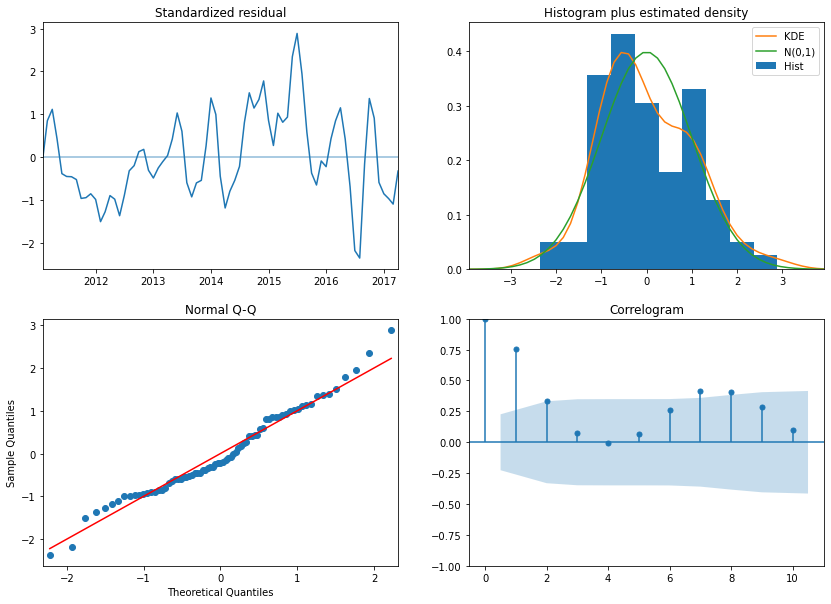

In [63]:
model_11222 = aa_model(train_11222, 3, 2)

RMSE: 56616.09338014847


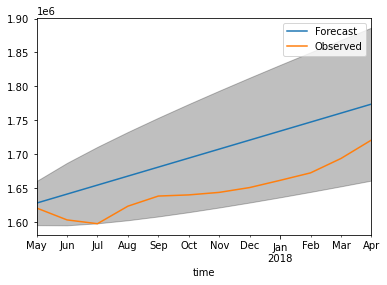

In [64]:
forecast_rmse(model_11222, test_11222)

RMSE: 15125.750670076952


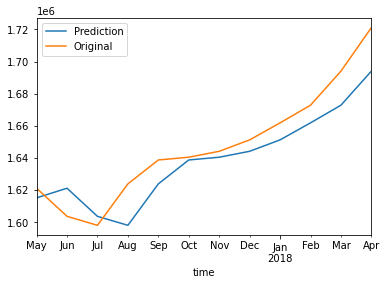

In [160]:
shifted_rmse(ts_11222)

In [105]:
model_results = model_results.append({'Zipcode': '11222',
                                      'forecast_rmse': 56616.09,
                                      'base_rmse': 15125.75}, ignore_index = True)

## 11238

In [252]:
ts_11238

,value
time,
2004-01-01,671200.0
2004-02-01,665400.0
2004-03-01,662500.0
2004-04-01,660200.0
2004-05-01,659200.0
...,...
2017-12-01,2768900.0
2018-01-01,2810700.0
2018-02-01,2848100.0


In [65]:
ts_11238, train_11238, test_11238 = split(top10, 11238)

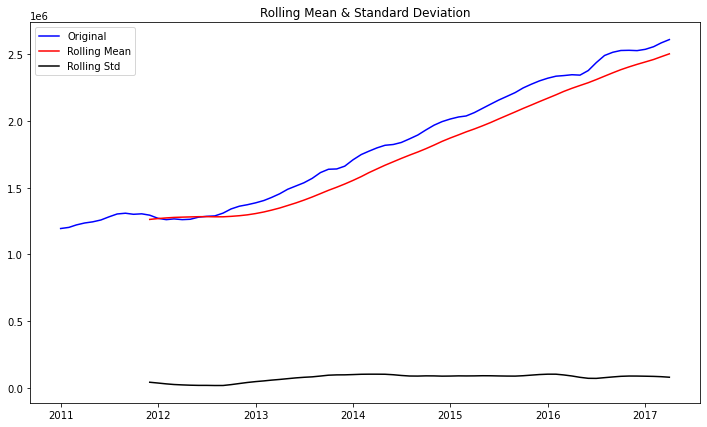

Test Statistic                  0.407642
p-value                         0.981778
#Lags Used                      6.000000
Number of Observations Used    69.000000
Critical Value (1%)            -3.528890
Critical Value (5%)            -2.904440
Critical Value (10%)           -2.589656
dtype: float64

In [168]:
stationarity_check(train_11238)

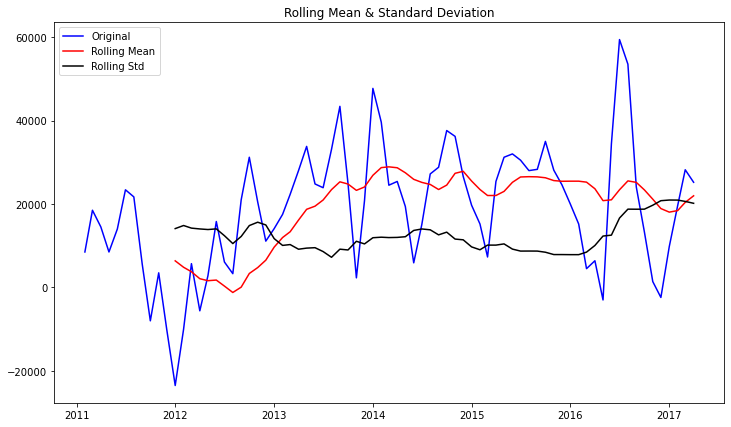

Test Statistic                 -1.873770
p-value                         0.344499
#Lags Used                      5.000000
Number of Observations Used    69.000000
Critical Value (1%)            -3.528890
Critical Value (5%)            -2.904440
Critical Value (10%)           -2.589656
dtype: float64

In [169]:
stationarity_check(train_11238.diff().dropna())

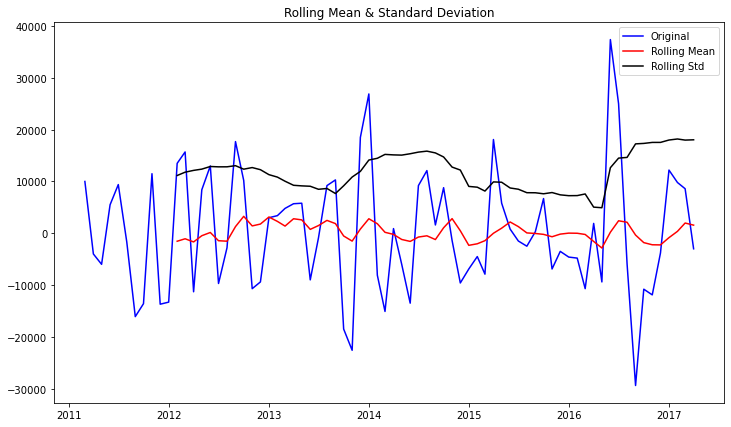

Test Statistic                 -5.360099
p-value                         0.000004
#Lags Used                      6.000000
Number of Observations Used    67.000000
Critical Value (1%)            -3.531955
Critical Value (5%)            -2.905755
Critical Value (10%)           -2.590357
dtype: float64

In [170]:
stationarity_check(train_11238.diff().diff().dropna())

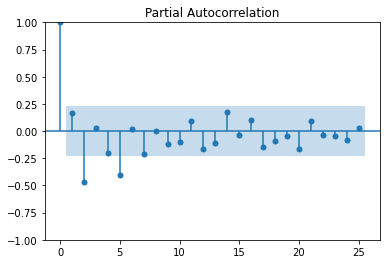

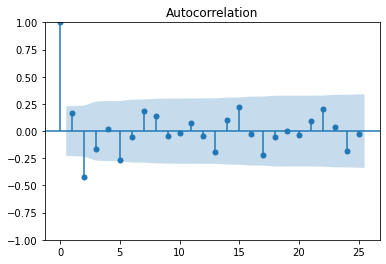

In [171]:
ts_diff = train_11238.diff().diff().dropna()



plot_pacf(ts_diff, lags = 25, method = 'ywm');
plot_acf(ts_diff, lags = 25);

 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=1601.799, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=1603.315, Time=0.03 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=1606.383, Time=0.05 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=1603.320, Time=0.02 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=1605.313, Time=0.07 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=1608.124, Time=0.04 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=1609.609, Time=0.05 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.24 sec

Best model:  ARIMA(0,2,0)(0,0,0)[0] intercept
Total fit time: 0.750 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   76
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -798.900
Date:                Wed, 01 Feb 2023   AIC                           1601.799
Time:                        02:37:14   BIC                           1606.407
Sample:                    01-01-2011   HQIC                          1603.638
                         - 04-01-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    225.6757   1417.016      0.159      0.873   -2551.625    3002.976
sigma2      1.396e+08   2.15e+07      6.486      0.000    9.74e+07    1.82e+08
===================================================================================
Ljung-Box (L1) (Q):                   2.22   Jarque-Bera (JB):                 2.36
Prob(Q):                              0.14   Prob(JB):                         0.31
Heteroskedasticity (H):               1.53   Skew:                             0.38
Prob(H) (two-sided):                  0.29   Kurtosis:                         3.42
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

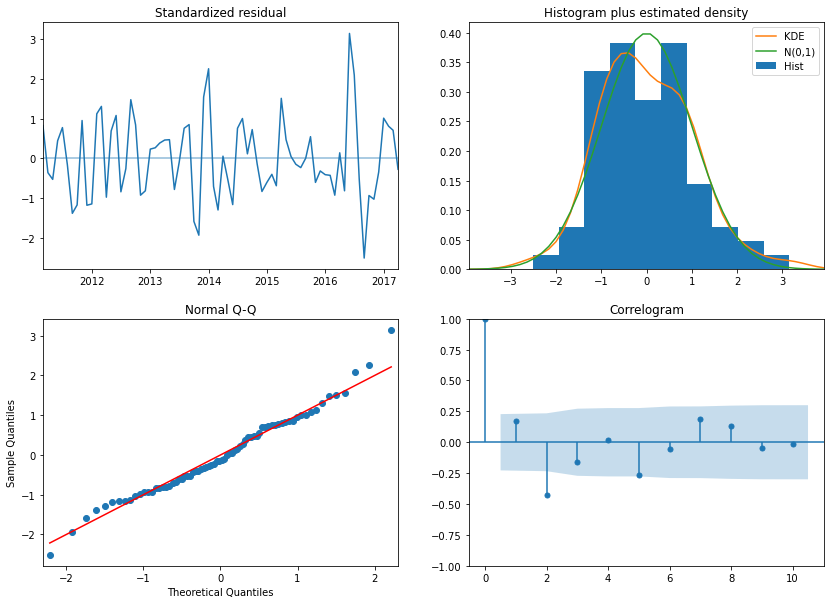

In [66]:
model_11238 = aa_model(train_11238, 2, 2)

RMSE: 32969.39072347842


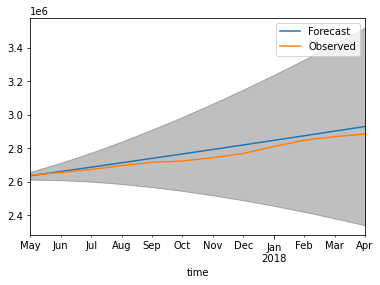

In [67]:
forecast_rmse(model_11238, test_11238)

RMSE: 24660.173694981684


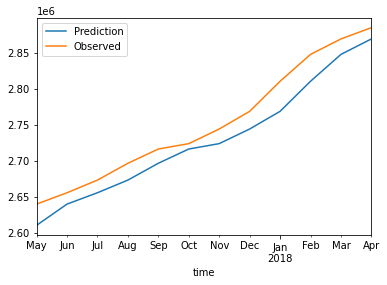

In [68]:
shifted_rmse(ts_11238)

In [106]:
model_results = model_results.append({'Zipcode': '11238',
                                      'forecast_rmse': 32969.39,
                                      'base_rmse': 24660.17}, ignore_index = True)

## 11102

In [69]:
ts_11102, train_11102, test_11102 = split(top10, 11102)

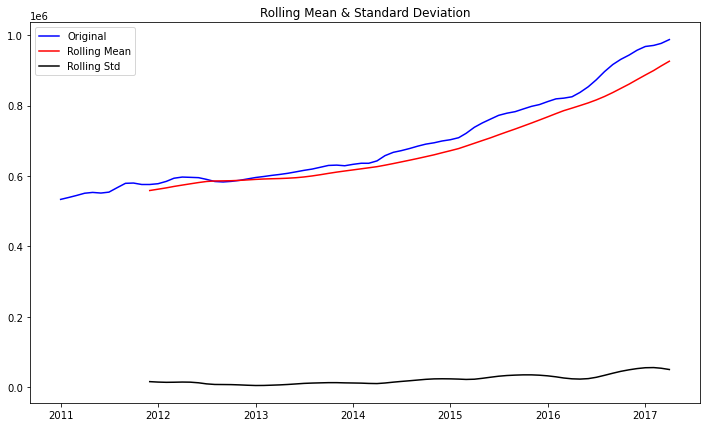

Test Statistic                  3.867860
p-value                         1.000000
#Lags Used                      7.000000
Number of Observations Used    68.000000
Critical Value (1%)            -3.530399
Critical Value (5%)            -2.905087
Critical Value (10%)           -2.590001
dtype: float64

In [176]:
stationarity_check(train_11102)

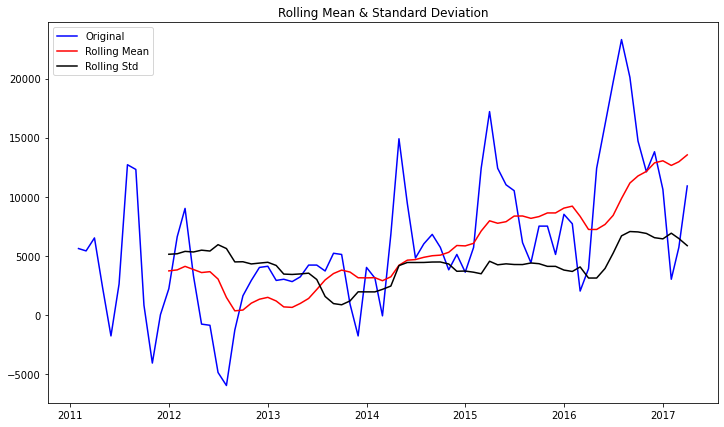

Test Statistic                 -1.996805
p-value                         0.287976
#Lags Used                      4.000000
Number of Observations Used    70.000000
Critical Value (1%)            -3.527426
Critical Value (5%)            -2.903811
Critical Value (10%)           -2.589320
dtype: float64

In [177]:
stationarity_check(train_11102.diff().dropna())

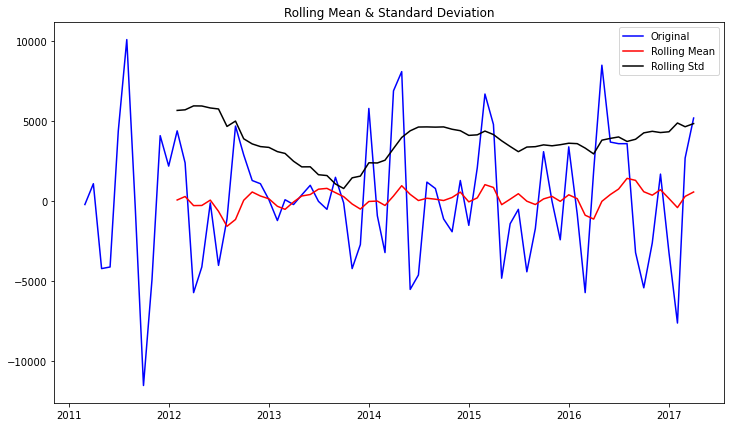

Test Statistic                 -4.505440
p-value                         0.000192
#Lags Used                     11.000000
Number of Observations Used    62.000000
Critical Value (1%)            -3.540523
Critical Value (5%)            -2.909427
Critical Value (10%)           -2.592314
dtype: float64

In [178]:
stationarity_check(train_11102.diff().diff().dropna())

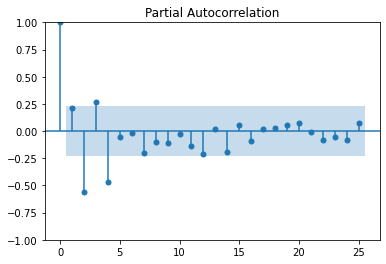

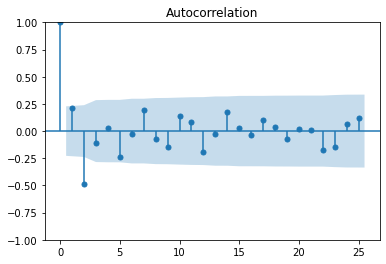

In [179]:
ts_diff = train_11102.diff().diff().dropna()



plot_pacf(ts_diff, lags = 25, method = 'ywm');
plot_acf(ts_diff, lags = 25);

 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=1439.803, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=1442.551, Time=0.04 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=1453.728, Time=0.03 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=1441.807, Time=0.05 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=1444.889, Time=0.04 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=1457.554, Time=0.07 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=1450.406, Time=0.08 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=1455.789, Time=0.05 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=1444.230, Time=0.37 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=1455.393, Time=0.06 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=1456.642, Time=0.15 sec
 ARIMA(3,2,2)(0,0,0)[0] intercept   : AIC=1441.846, Time=0.32 sec
 ARIMA(4,2,0)(0,0,0)[0] intercept   : AIC=1471.587, Time=0.07 sec
 ARIMA(4,2,1)(0,0,0)[0] intercept   : AIC=1449.138, Time=0.24 sec

Best model:  ARIMA(0,2,0)(0,0,0)[0] intercept
Total fit time: 1.610 seconds

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   76
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -717.902
Date:                Wed, 01 Feb 2023   AIC                           1439.803
Time:                        02:37:44   BIC                           1444.411
Sample:                    01-01-2011   HQIC                          1441.641
                         - 04-01-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     71.6216    459.648      0.156      0.876    -829.272     972.516
sigma2      1.563e+07   2.46e+06      6.359      0.000    1.08e+07    2.05e+07
===================================================================================
Ljung-Box (L1) (Q):                   3.59   Jarque-Bera (JB):                 0.11
Prob(Q):                              0.06   Prob(JB):                         0.95
Heteroskedasticity (H):               0.86   Skew:                             0.02
Prob(H) (two-sided):                  0.71   Kurtosis:                         3.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

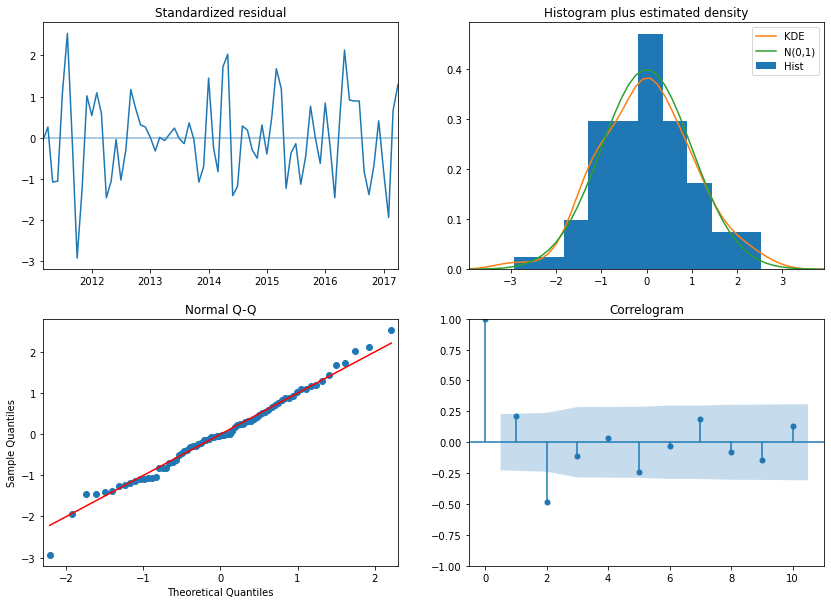

In [70]:
model_11102 = aa_model(train_11102, 4, 2)

RMSE: 24581.23661476507


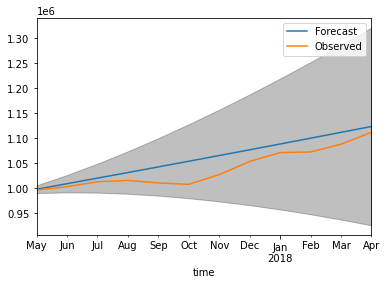

In [71]:
forecast_rmse(model_11102, test_11102)

RMSE: 14333.294573591005


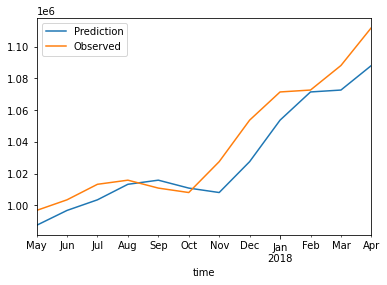

In [184]:
shifted_rmse(ts_11102)

In [107]:
model_results = model_results.append({'Zipcode': '11102',
                                      'forecast_rmse': 24581.23,
                                      'base_rmse': 14333.29}, ignore_index = True)

## 11211

In [72]:
ts_11211, train_11211, test_11211 = split(top10, 11211)

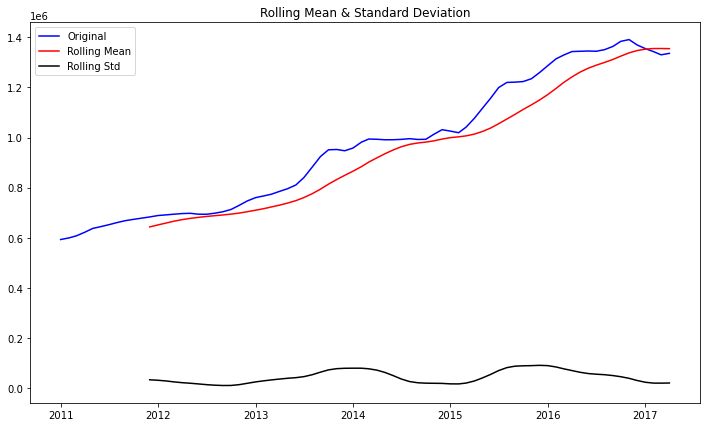

Test Statistic                  0.314900
p-value                         0.978018
#Lags Used                     10.000000
Number of Observations Used    65.000000
Critical Value (1%)            -3.535217
Critical Value (5%)            -2.907154
Critical Value (10%)           -2.591103
dtype: float64

In [189]:
stationarity_check(train_11211)

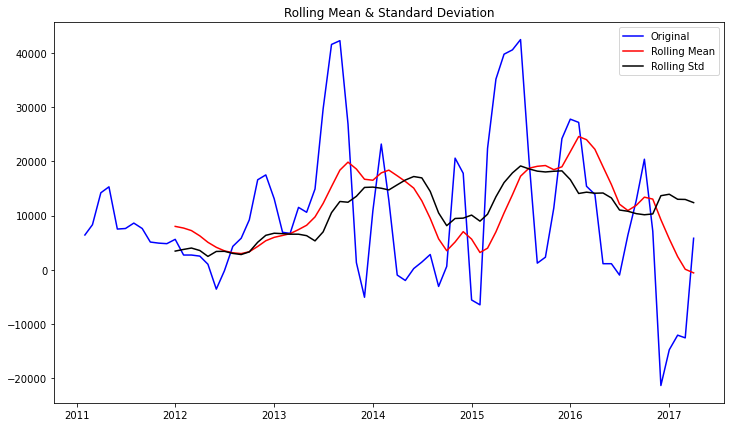

Test Statistic                 -3.366010
p-value                         0.012174
#Lags Used                      9.000000
Number of Observations Used    65.000000
Critical Value (1%)            -3.535217
Critical Value (5%)            -2.907154
Critical Value (10%)           -2.591103
dtype: float64

In [190]:
stationarity_check(train_11211.diff().dropna())

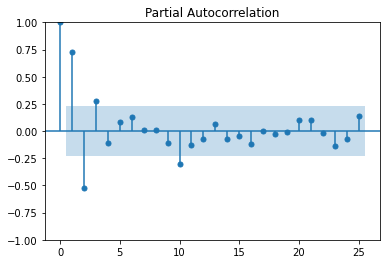

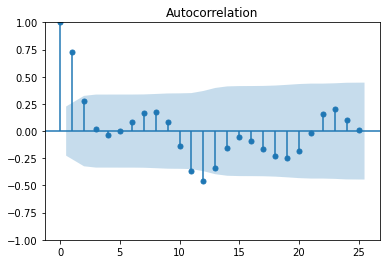

In [191]:
ts_diff = train_11211.diff().dropna()



plot_pacf(ts_diff, lags = 25, method = 'ywm');
plot_acf(ts_diff, lags = 25);

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1641.732, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1661.662, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1705.700, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1644.702, Time=0.13 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1729.870, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1713.633, Time=0.08 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=1757.200, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1715.632, Time=0.11 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.530 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   76
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -818.866
Date:                Wed, 01 Feb 2023   AIC                           1641.732
Time:                        02:37:57   BIC                           1646.367
Sample:                    01-01-2011   HQIC                          1643.583
                         - 04-01-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   9921.3333   1680.176      5.905      0.000    6628.250    1.32e+04
sigma2      1.782e+08    2.9e+07      6.155      0.000    1.21e+08    2.35e+08
===================================================================================
Ljung-Box (L1) (Q):                  40.94   Jarque-Bera (JB):                 5.25
Prob(Q):                              0.00   Prob(JB):                         0.07
Heteroskedasticity (H):               8.82   Skew:                             0.62
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

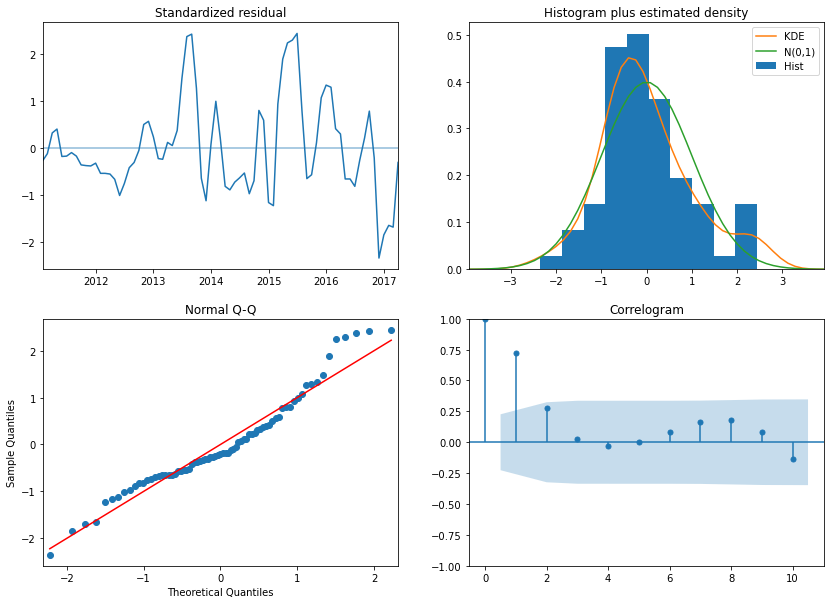

In [73]:
model_11211 = aa_model(train_11211, 3, 1)

RMSE: 77917.0123818836


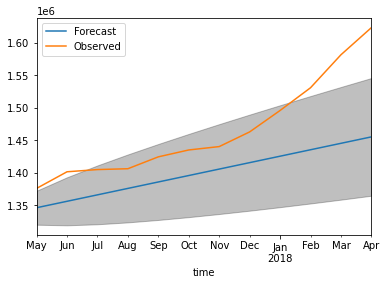

In [74]:
forecast_rmse(model_11211, test_11211)

RMSE: 28681.628847283646


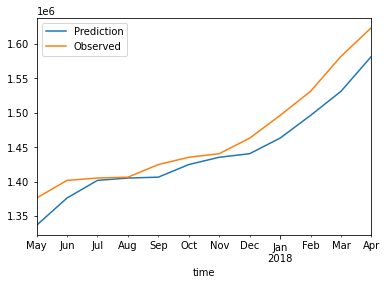

In [197]:
shifted_rmse(ts_11211)

In [108]:
model_results = model_results.append({'Zipcode': '11211',
                                      'forecast_rmse': 77917.01,
                                      'base_rmse': 28681.62}, ignore_index = True)

## Forecasting top 5

In [109]:
model_results

,Zipcode,base_rmse,forecast_rmse
0,11355,6087.35,4310.58
1,11354,8132.29,5819.31
2,11224,4742.88,20700.02
3,11105,7287.54,45008.30
4,11229,6870.83,12927.98
5,11694,7198.55,7075.32
6,11222,15125.75,56616.09
7,11238,24660.17,32969.39
8,11102,14333.29,24581.23
9,11211,28681.62,77917.01


In [110]:
model_results['rmse_diff'] = model_results['forecast_rmse'] - model_results['base_rmse']

In [111]:
model_results.sort_values('rmse_diff', ascending = True)

,Zipcode,base_rmse,forecast_rmse,rmse_diff
1,11354,8132.29,5819.31,-2312.98
0,11355,6087.35,4310.58,-1776.77
5,11694,7198.55,7075.32,-123.23
4,11229,6870.83,12927.98,6057.15
7,11238,24660.17,32969.39,8309.22
8,11102,14333.29,24581.23,10247.94
2,11224,4742.88,20700.02,15957.14
3,11105,7287.54,45008.30,37720.76
6,11222,15125.75,56616.09,41490.34
9,11211,28681.62,77917.01,49235.39


In [241]:
def forecast_plot(model, observed, period):
    forecast_range = pd.date_range(start = '05-01-2018', 
                                   periods = period, 
                                   freq = 'MS')
    prediction, confint = model.predict(n_periods=12, 
                                        return_conf_int=True)

    forecast = pd.Series(prediction, index = forecast_range)
    obs = observed['2011-01':]

    fig, ax = plt.subplots(figsize = (14,10))
    ax.plot(obs, label = 'Observed')
    ax.plot(forecast, label = 'Forecast')
    ax.legend(loc = 'upper left')
    ax.fill_between(forecast_range,
                    confint[:,0],
                    confint[:,1], color='k', alpha=0.25);
    cost = observed['value'].values[-1]
    ret = prediction[-1]
    max_ret = confint[-1][1]
    min_ret = confint[-1][0]
    roi = round((ret - cost) / cost, 3)
    max_roi = round((max_ret - cost) / cost, 3)
    min_roi = round((min_ret - cost) / cost, 3)
    print(f'ROI:{roi}', f'Max ROI:{max_roi}', f'Min ROI:{min_roi}', sep = '\n')
    print(f'+/-:{max_roi - roi}')

In [112]:
model_11355.update(test_11355)

ARIMA(order=(2, 2, 2), scoring_args={}, suppress_warnings=True)

In [114]:
forecast_range = pd.date_range(start = '05-01-2018', periods = 12, freq = 'MS')

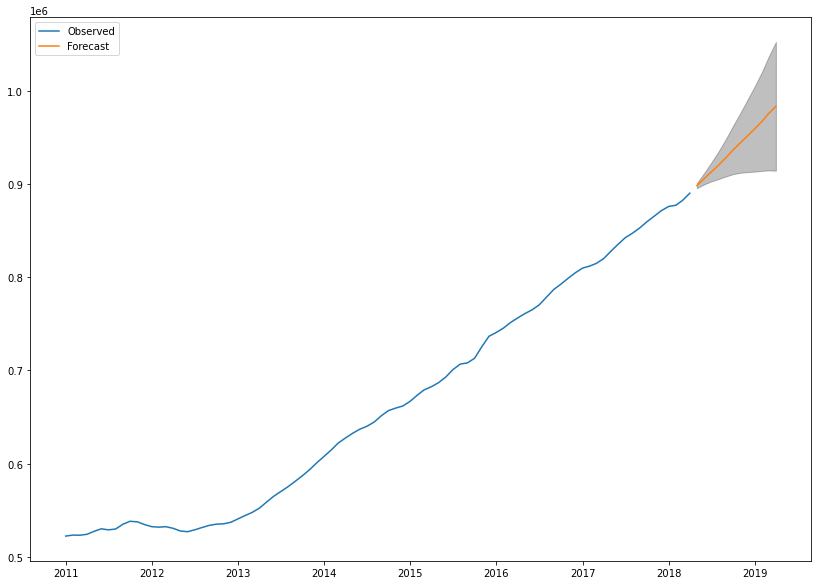

In [133]:
prediction, confint = model_11355.predict(n_periods=12, return_conf_int=True)

forecast = pd.Series(prediction, index = forecast_range)
observed = ts_11355['2011-01':]

fig, ax = plt.subplots(figsize = (14,10))
ax.plot(observed, label = 'Observed')
ax.plot(forecast, label = 'Forecast')
ax.legend(loc = 'upper left')
ax.fill_between(forecast_range,
                confint[:,0],
                confint[:,1], color='k', alpha=0.25);
    

In [227]:
print(f'ROI:{round(a,2)}', f'MAX ROI:{round(b,3)}', f'MIN ROI:{round(c,3)}', sep = '\n')

ROI:983433.75
MAX ROI:0.182
MIN ROI:0.027


ROI:0.105
Max ROI:0.182
Min ROI:0.027
+/-:0.077


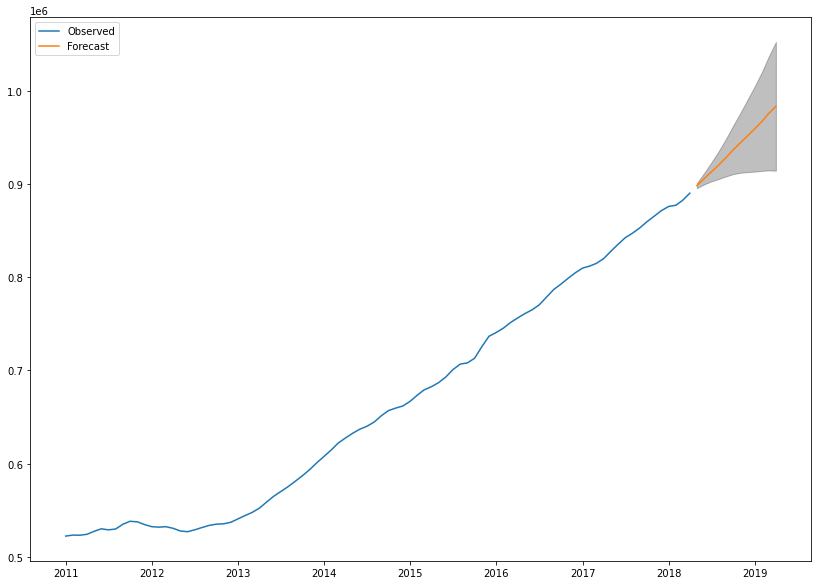

In [251]:
forecast_plot(model_11355, ts_11355, 12)

In [146]:
model_11354.update(test_11354)

ARIMA(order=(3, 2, 2), scoring_args={}, suppress_warnings=True)

ROI:0.077
Max ROI:0.174
Min ROI:-0.019
+/-:0.09699999999999999


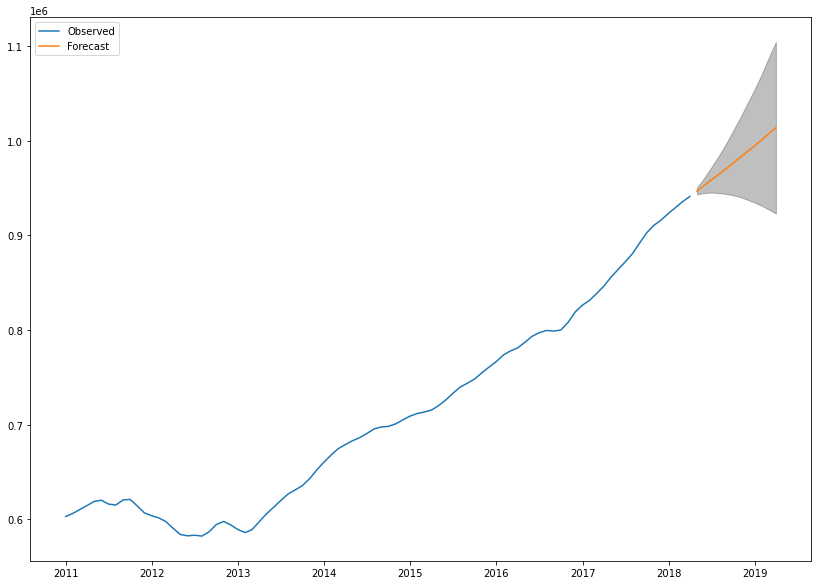

In [250]:
forecast_plot(model_11354, ts_11354, 12)

ROI:0.132
Max ROI:0.414
Min ROI:-0.15
+/-:0.282


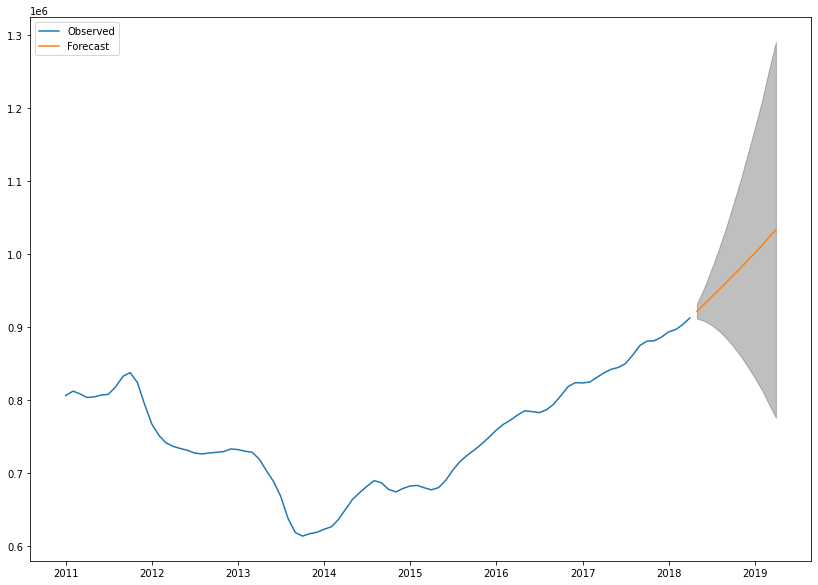

In [249]:
model_11694.update(test_11694)
forecast_plot(model_11694, ts_11694, 12)

ROI:0.143
Max ROI:0.225
Min ROI:0.06
+/-:0.08200000000000002


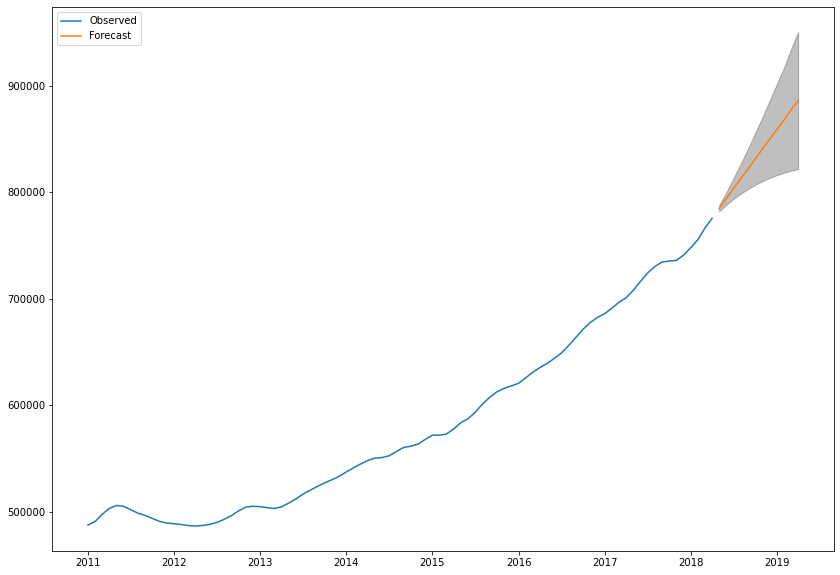

In [248]:
model_11229.update(test_11229)
forecast_plot(model_11229, ts_11229, 12)

ROI:0.069
Max ROI:0.838
Min ROI:-0.701
+/-:0.7689999999999999


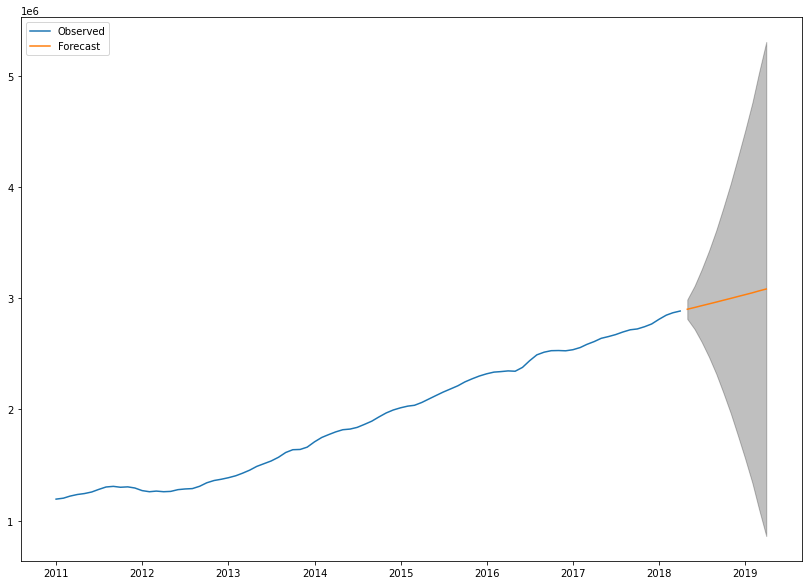

In [247]:
model_11238.update(test_11238)
forecast_plot(model_11238, ts_11238, 12)

In [234]:
model_11102.update(test_11102)

ARIMA(order=(0, 2, 0), scoring_args={}, suppress_warnings=True)

ROI:0.271
Max ROI:0.507
Min ROI:0.034
+/-:0.236


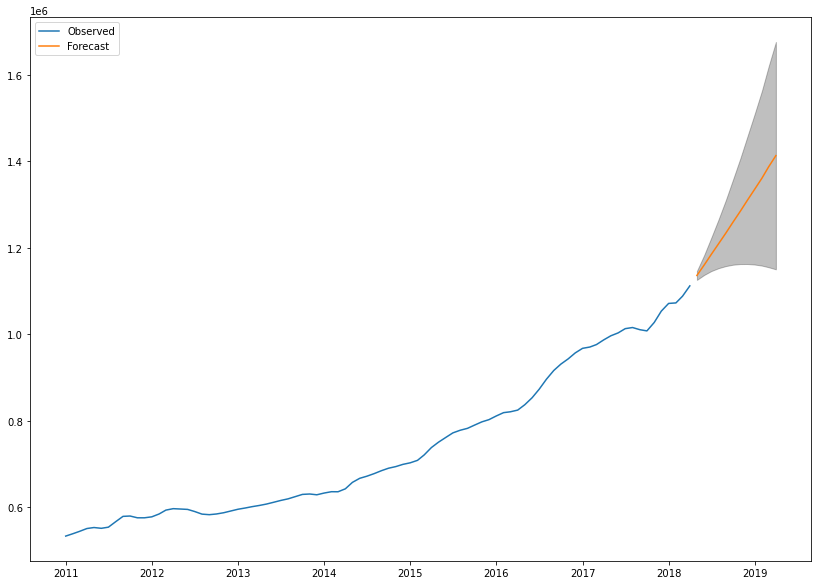

In [246]:
forecast_plot(model_11102, ts_11102, 12)

ROI:0.041
Max ROI:0.134
Min ROI:-0.052
+/-:0.093


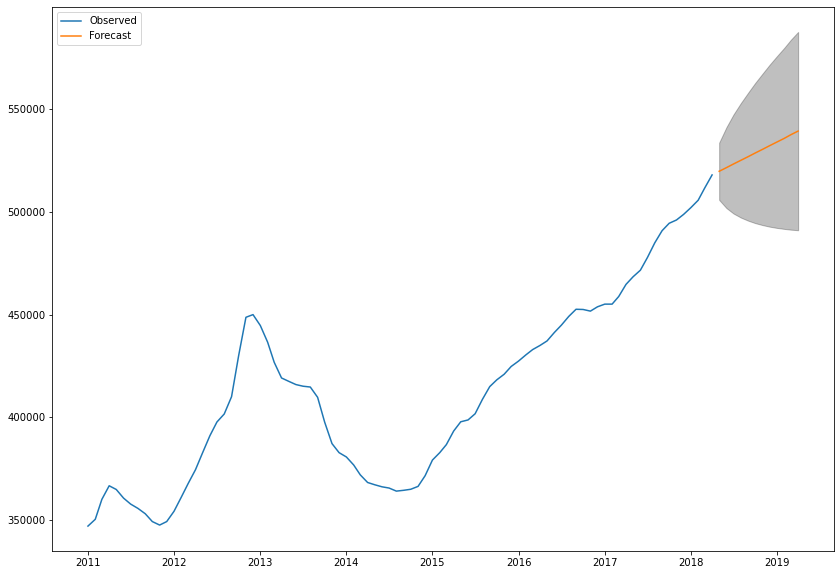

In [245]:
model_11224.update(test_11224)
forecast_plot(model_11224, ts_11224, 12)

ROI:0.153
Max ROI:0.484
Min ROI:-0.177
+/-:0.33099999999999996


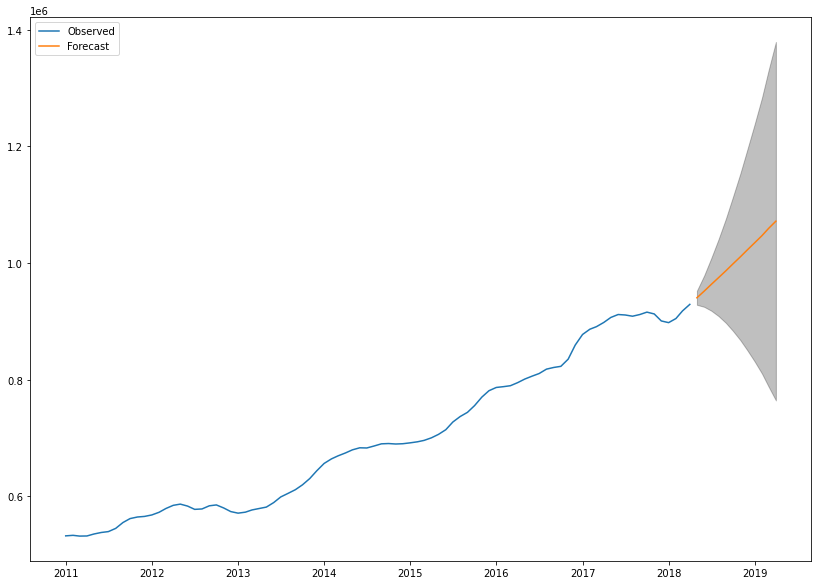

In [244]:
model_11105.update(test_11105)
forecast_plot(model_11105, ts_11105, 12)

ROI:0.085
Max ROI:0.159
Min ROI:0.011
+/-:0.074


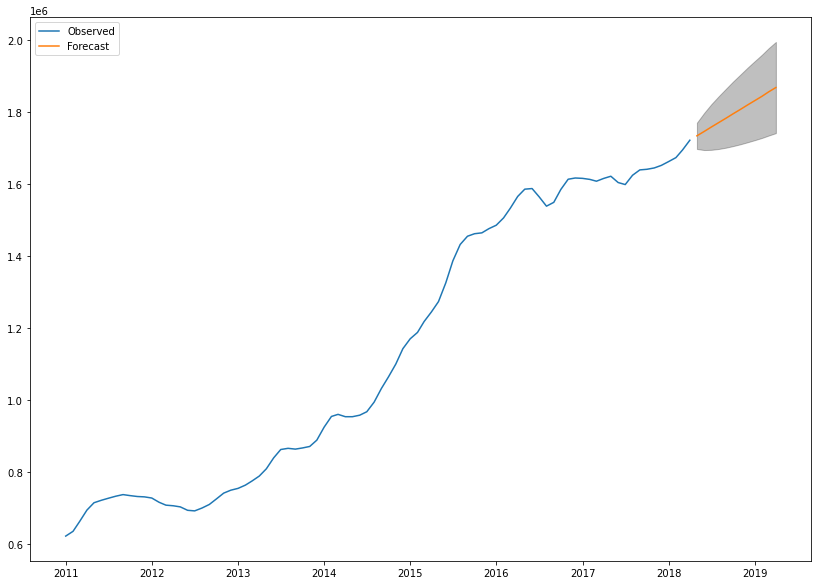

In [243]:
model_11222.update(test_11222)
forecast_plot(model_11222, ts_11222, 12)

ROI:0.079
Max ROI:0.194
Min ROI:-0.036
+/-:0.115


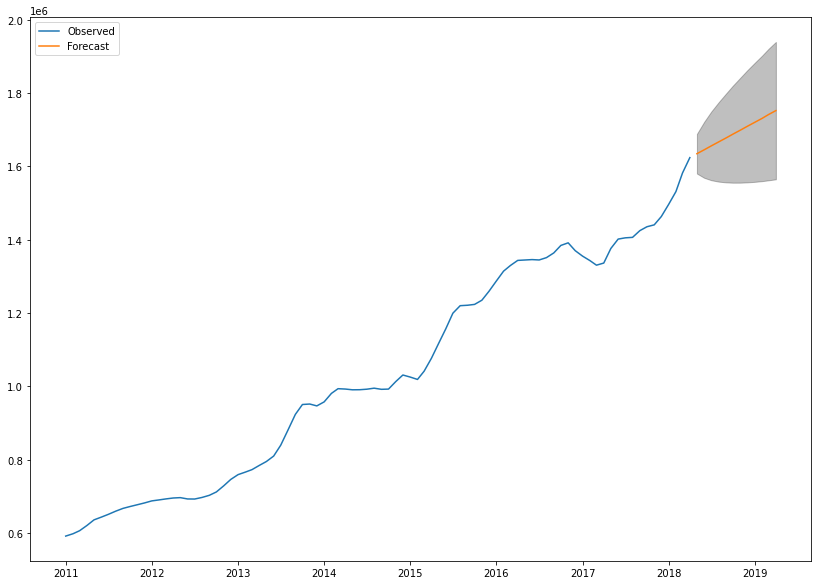

In [242]:
model_11211.update(test_11211)
forecast_plot(model_11211, ts_11211, 12)